In [1]:
library(reshape2)
library(dplyr)
library(igraph)

## Plotting
library(pROC)
library(ggplot2)
theme_set(theme_gray())
library(cowplot)
library(rgl)
library(RColorBrewer)
library(pheatmap)
library(UpSetR)
library(VennDiagram)
library(xtable)
library(Rtsne)
# library(dendextend)
library(repr)
options(repr.plot.width=8, repr.plot.height=4)

library(limma)
library(sva)

## Custom
source("../functions.R")


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘igraph’

The following objects are masked from ‘package:dplyr’:

    as_data_frame, groups, union

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Type 'citation("pROC")' for a citation.

Attaching package: ‘pROC’

The following objects are masked from ‘package:stats’:

    cov, smooth, var


********************************************************
Note: As of version 1.0.0, cowplot does not change the
  default ggplot2 theme anymore. To recover the previous
  behavior, execute:
  theme_set(theme_cowplot())
********************************************************

Warning message in rgl.init(initValue, onlyNULL):
“RGL: unable to open X11 display”Warning message:
“'rgl_init' f

In [2]:
# FUNCTIONS ---------------------------------------------------------------
plot_mean <- function(df, batch_vec1) {
  # Melt dataframe
  melt_df <- melt(df, variable.name = "ID")
  print(head(melt_df))
  # Trimmed mean probe intensities for each chip
  mean_tibble <- melt_df %>% group_by(ID) %>%
    summarise(mean = mean(value))
  mean_batch_tibble <- cbind(mean_tibble,
                             batch_vec1 = batch_vec1[mean_tibble$ID])
  
  mean_scatter <- ggplot(mean_batch_tibble, aes(x = ID, y = mean)) +
    geom_point(aes(col = factor(batch_vec1)),
               show.legend = F, size = 3) +
    facet_wrap(factor(batch_vec1), scales = "free_x") +
    theme(axis.text.x = element_blank(), axis.ticks.x = element_blank())
  return(mean_scatter)
}

# Selecting drug responsive genes between D0 and D8
# using paired t-test and logfc
selectFeatures <- function(df1, metadata_df,
                           alpha = 0.05, logfc_threshold = 1) {
  # Subset df according to D0 and D8
  class_info <- metadata_df[colnames(df1), "class_info"]
  df_d0 <- df1[,class_info == "D0"]
  df_d8 <- df1[,class_info == "D8"]
  print(head(colnames(df_d0)))
  print(head(colnames(df_d8)))
  stopifnot(ncol(df_d0) == ncol(df_d8))
  
  # Identify drug responsive probesets
  ttest_pvalue <- calc_ttest(cbind(df_d0, df_d8), ncol(df_d0), is_paired = T)
  log_fc <- rowMeans(df_d8) - rowMeans(df_d0)
  ttest_probesets <- names(ttest_pvalue)[ttest_pvalue <= alpha]
  fc_probesets <- names(log_fc)[log_fc > logfc_threshold]
  intersect_probesets <- intersect(ttest_probesets, fc_probesets)
  print(paste("T-test:", length(ttest_probesets)))
  print(paste("Log fold change:", length(fc_probesets)))
  print(paste("Intersection:", length(intersect_probesets)))
  return(intersect_probesets)
}

# 3D PCA plot
plotPCA3D <- function(df, colour, pch, pc_labels = NULL,
                      ratio_list = list(2,1,1)) {
  if (is.null(pc_labels)) {
    print("PCA performed!")
    pca_obj <- prcomp(t(df), center = T, scale. = F)
    pca_df <- as.data.frame(pca_obj$x[,1:3])
    eigenvalues <- (pca_obj$sdev)^2
    var_pc <- eigenvalues[1:3]/sum(eigenvalues)
    print(var_pc)
    pc_labels <- sprintf("PC%d (%.2f%%)", 1:3, var_pc*100)
  } else {
    print("No PCA performed!")
    pca_df <- as.data.frame(df)
  }
  
  # RGL plot parameters
  rgl.open()
  rgl.bg(color="white")
  rgl.viewpoint(zoom = 0.8)
  # rgl.viewpoint(theta = 110, phi = 5, zoom = 0.8)
  par3d(windowRect = c(50, 20, 500, 500))
  with(pca_df, pch3d(PC1, PC2, PC3, bg = colour,
                     pch = pch, cex = 0.5, lwd = 1.5))
  box3d(col = "black")
  title3d(xlab = pc_labels[1], ylab = pc_labels[2],
          zlab = pc_labels[3], col = "black")
  # Plot aspect ratios of axis according to variance
  do.call(aspect3d, ratio_list)
}

# Plot PCA before selecting features
# Batch information of all the timepoints
plotPCA3DYeoh <- function(df1, metadata_df) {
  batch_info <- metadata_df[colnames(df1), "batch_info"]
  generate_colour <- colorRampPalette(c("lightblue", "darkblue"))
  batch_palette <- generate_colour(10)
  # batch_palette <- brewer.pal(10, "Set3")
  batch_colour <- batch_palette[batch_info]
  # Shape of all timepoints
  class_info <- metadata_df[colnames(df1), "class_info"]
  print(levels(class_info))
  levels(class_info) <- 21:23
  timepoint_shape <- as.numeric(as.character(class_info))
  plotPCA3D(df1, batch_colour, timepoint_shape)
}

# Plot PCA before selecting features
# Batch information of all the timepoints
plotPCA3DYeoh1 <- function(df1, metadata_df) {
  batch_info <- metadata_df[colnames(df1), "batch_info"]
  batch_factor <- droplevels(as.factor(batch_info))
  print(batch_factor)
  print(levels(batch_factor))
  levels(batch_factor) <- 21:22
  pch <- as.numeric(as.character(batch_factor))
  # generate_colour <- colorRampPalette(c("lightblue", "darkblue"))
  # batch_palette <- generate_colour(10)
  
  # Shape of all timepoints
  class_info <- metadata_df[colnames(df1), "subtype"]
  palette <- brewer.pal(10, "Set3")
  col <- palette[class_info]
  
  plotPCA3D(df1, col, pch)
}

plotJitterYeoh <- function(X, metadata_df, n_pc = 10) {
  pca_obj <- prcomp(t(X))
  X_pca <- data.frame(pca_obj$x)
  batch <- as.factor(metadata_df[rownames(X_pca),"batch_info"])
  class <- as.factor(metadata_df[rownames(X_pca),"class_info"])
  X_meta <- cbind(batch, class, X_pca[,1:n_pc])
  X_long <- melt(X_meta, id = c("batch", "class"), variable.name="PC")
  
  ax_batch <- ggplot(X_long, aes(x=PC, y=value)) +
    # geom_boxplot(aes(fill=batch), alpha=0.3, outlier.shape=NA) +
    geom_point(aes(colour=batch), position=position_jitterdodge(),
               size = 1, alpha = 1.0)
  
  ax_class <- ggplot(X_long, aes(x=PC, y=value)) +
    # geom_boxplot(aes(fill=class), alpha=0.3, outlier.shape=NA) +
    geom_point(aes(colour=class), position=position_jitterdodge(),
               size = 1, alpha = 1.0)
  
  fig <- plot_grid(ax_batch, ax_class, nrow = 2)
  return(fig)  
}

plotFeatures <- function(results, metadata_df) {
  y <- as.factor(metadata_df[rownames(results),"label"])
  subset_features1 <- c("erm1", "angle_d0d8_normal", "l2norm_d0_d8",
                        "l2norm_d0_normal", "l2norm_d8_normal", "l2norm_diff",
                        "erm1_ratio1", "erm1_ratio2", "erm1_ratio3",
                        "l2norm_ratio1", "l2norm_ratio2", "l2norm_diff_ratio")
  
  features1 <- results[, subset_features1, drop=F]
  features1_y <- data.frame(features1, label = y)
  long_features1_y <- melt(features1_y, id="label", variable.name = "feature")
  
  # PLOT: FEATURES
  jitter_features1 <- ggplot(long_features1_y) +
    geom_point(aes(feature, value, colour = label),
               position = position_jitterdodge(), cex = 3,
               show.legend = F) +
    scale_color_manual(values = c("darkolivegreen3", "tomato3")) +
    facet_wrap(~feature, nrow = 2, ncol = 6,  scales = "free") +
    theme(axis.title.x=element_blank(),
          axis.text.x=element_text(angle = 10, vjust = 0.5))
  
  return(jitter_features1)
}

# Factor to split data
splitSubtype <- function(X, metadata_df) {
  if (!is(X, "data.frame"))
    X <- data.frame(X)
  
  subtype_factor <- as.factor(metadata_df[colnames(X), "subtype"])
  split.default(X, subtype_factor, drop = F) # Split by subtype
}

## Import data

In [27]:
## Metadata
METADATA_RPATH <- "data/GSE67684/processed/metadata/full_metadata.tsv"
metadata_df <- read.table(METADATA_RPATH, sep = "\t")
BATCH_RPATH <- "data/GSE67684/processed/metadata/metadata-batch.tsv"
LABEL_RPATH <- "data/GSE67684/processed/metadata/metadata-label_mrd_subtype.tsv"
yeoh_batch <- read.table(BATCH_RPATH, sep = "\t", header = T, row.names = 1)
yeoh_label <- read.table(LABEL_RPATH, sep = "\t", header = T, row.names = 1)

## Subset of original data
# Removed outliers, patients with timepoints from different batches and batch 5
SUBSET_RPATH <- "data/GSE67684/processed/subset_yeoh.tsv"
raw_yeoh <- read.table(SUBSET_RPATH, sep = "\t")
# SCALE->REMOVE->FILTER->LOG
scaled_yeoh <- normaliseMeanScaling(raw_yeoh)
selected_yeoh <- removeProbesets(scaled_yeoh)
data <- log2_transform(filterProbesets(selected_yeoh, 0.7, metadata_df))

  P001_D0   P004_D0   P005_D0   P007_D0   P008_D0   P009_D0 
 5.796952  4.123342  3.981577  6.317643  4.841458 11.978124 
[1] "No. of ambiguous and AFFY probesets removed: 10503"
[1] D0 D0 D0 D0 D0 D0
Levels: D0 D8 N
           D0    D8     N
1053_at  TRUE  TRUE  TRUE
117_at  FALSE  TRUE  TRUE
121_at   TRUE  TRUE  TRUE
1294_at  TRUE  TRUE  TRUE
1316_at  TRUE  TRUE  TRUE
1320_at FALSE FALSE FALSE
[1] "No. of probesets removed = 6321"


#### Import D33 samples

In [96]:
## Metadata
METADATA_RPATH1 <- "data/GSE67684/processed/metadata/all_metadata.tsv"
all_metadata <- read.table(METADATA_RPATH1, sep = "\t")

# SCALE->REMOVE->FILTER->LOG
D33_RPATH <- "data/leuk_D33/processed/mas5_filtered.tsv"
raw_d33 <- read.table(D33_RPATH, sep = "\t")
log_d33 <- log2_transform(normaliseMeanScaling(raw_d33))
fltr_d33 <- log_d33[rownames(data),]

## Filter out D33 patients without D0/D8 data
pid_d33 <- substring(colnames(fltr_d33), 1, 4)
pid_d0d8 <- substring(rownames(metadata_df), 1, 4)
rm_d33 <- paste0(pid_d33[!(pid_d33 %in% pid_d0d8)], "_D33")
data_d33 <- fltr_d33[,!(colnames(fltr_d33) %in% rm_d33)]
print(rm_d33)

# Combine D33 with the rest
data_all <- cbind(data, data_d33)

P001_D33 P006_D33 P007_D33 P008_D33 P009_D33 P010_D33 
2.106859 2.132480 1.498776 2.559182 1.576584 2.657973 
[1] "P006_D33" "P030_D33" "P069_D33" "P074_D33" "P079_D33"


### Commonly used globals

In [4]:
Y <- metadata_df[colnames(data),]
Y_annot <- Y[,c("batch_info", "label")] # heatmap annot
# Y_all <- all_metadata[colnames(data_all),]

pid_remission <- rownames(Y)[Y$label == 0]

# List subtypes
all_subtypes <- levels(metadata_df$subtype)
subtypes <- setdiff(all_subtypes, c("Hypodiploid", "Normal"))

## Subsetting data

In [36]:
##### SUBSETTING DATA ######
## Normal
idx_normal <- metadata_df[colnames(data), "subtype"] == "Normal"
normal <- data[,idx_normal]

## Hyperdiploid
idx_hyp <- metadata_df[colnames(data), "subtype"] == "Hyperdiploid" &
  metadata_df[colnames(data), "class_info"] == "D0"
hyperdiploid <- data[,idx_hyp]
colnames(hyperdiploid) <- substring(colnames(hyperdiploid), 1, 4)

# ## Hyperdiploid (D8)
# idx_hyp_d8 <- metadata_df[colnames(data), "subtype"] == "Hyperdiploid" &
#   metadata_df[colnames(data), "class_info"] == "D8"
# hyperdiploid_d8 <- data[,idx_hyp_d8]
# colnames(hyperdiploid_d8) <- substring(colnames(hyperdiploid_d8), 1, 4)

# ## TEL-AML1
# idx_telaml1 <- metadata_df[colnames(data), "subtype"] == "TEL-AML1" &
#   metadata_df[colnames(data), "class_info"] == "D0"
# telaml1 <- data[,idx_telaml1]
# colnames(telaml1) <- substring(colnames(telaml1), 1, 4)

# ## MLL
# idx_mll <- metadata_df[colnames(data), "subtype"] == "MLL" &
#   metadata_df[colnames(data), "class_info"] == "D0"
# mll <- data[,idx_mll]
# colnames(mll) <- substring(colnames(mll), 1, 4)

#### Combinations

In [617]:
# ## Hyperdiploid (D0 & D8) and Normal
# idx_hypall_norm <- (idx_hyp | idx_hyp_d8 | idx_normal)
# hypall_norm <- data[,idx_hypall_norm]

In [282]:
# ## All hyperdiploid & normal
# all_hyp_norm <- cbind(hypall_norm, hyperdiploid_d33)

ERROR: Error in cbind(hypall_norm, hyperdiploid_d33): object 'hyperdiploid_d33' not found


## Remove zeros (across all patients)

In [ ]:
# ##### FILTER OUT ZEROS (ALL PATIENTS) #####
# row_pct_nonzero <- rowSums(hyperdiploid != 0)/ncol(hyperdiploid)
# PCT_THRESHOLD <- 0.7
# ps_idx <- names(row_pct_nonzero)[row_pct_nonzero > PCT_THRESHOLD]

# normal1 <- normal[ps_idx,]
# hyperdiploid1 <- hyperdiploid[ps_idx,]
# hyp_normal1 <- cbind(hyperdiploid1, normal1)

## Chr annotation

In [37]:
## Annotation: Chr location
ANNOT_RPATH <- "../info/microarray/HG-U133_Plus_2/affymetrix/HG-U133_Plus_2.na35.annot.csv"
annot <- read.csv(ANNOT_RPATH,  row.names = 1, comment.char = "#")

get_chrloc <- function(ps, annot) {
  ps_chrloc <- annot[ps, "Chromosomal.Location"]
  ps_chr <- sub("(chr.*?)(p|q|c).*", "\\1", ps_chrloc)
  ps_chr[ps_chr == "---"] <- NA
  names(ps_chr) <- ps
  return(ps_chr)
}

ps_chr <- get_chrloc(rownames(data), annot)
print(length(ps_chr))

[1] 5453


## Summary statistics

In [38]:
##### CHR SUMMARY STATISTICS #####
### NORMAL
list_chr_norm <- split.data.frame(normal, ps_chr)
## MEAN
norm_mean <- t(sapply(list_chr_norm, colMeans))[1:22,]
## MEDIAN
norm_median <- t(sapply(list_chr_norm, apply, 2, median))[1:22,]
## MEDIAN (NO ZERO)
maspore_norm_fltr_median <- t(sapply(
  list_chr_norm,
  apply, 2, function(vec) median(vec[vec != 0])
))[1:22,]

## PCT ZERO
norm_pct_zero <- t(sapply(list_chr_norm, apply, 2,
                     function(vec) sum(vec == 0)/length(vec)))[1:22,]

### HYPERDIPLOID
list_chr_hyp <- split.data.frame(hyperdiploid, ps_chr)
## MEAN
hyp_mean <- t(sapply(list_chr_hyp, colMeans))[1:22,]
## MEDIAN
hyp_median <- t(sapply(list_chr_hyp, apply, 2, median))[1:22,]
## ## MEDIAN (NO ZERO)
maspore_hyp_fltr_median <- t(sapply(
  list_chr_hyp,
  apply, 2, function(vec) median(vec[vec != 0])
))[1:22,]

## PCT ZERO
hyp_pct_zero <- t(sapply(list_chr_hyp, apply, 2,
                         function(vec) sum(vec == 0)/length(vec)))[1:22,]

In [374]:
## Hyperdiploid (D0 & D8) - Normal
list_chr_hypall_norm <- split.data.frame(hypall_norm, ps_chr)
## MEDIAN
hypall_norm_median <- t(sapply(list_chr_hypall_norm, apply, 2, median))[1:22,]

In [375]:
## Hyperdiploid (D0, D8, D33) - Normal
list_chr_all_hyp_norm <- split.data.frame(all_hyp_norm, ps_chr)

In [455]:
## Entire dataset
list_chr_all <- split.data.frame(data_yeoh, ps_chr)
## MEDIAN
all_median <- t(sapply(list_chr_all, apply, 2, median))[1:22,]

#### Plotting

In [13]:
## FUNCTIONS
plot_chr_hyp <- function(X_subtype, X_norm, wpath1, wpath2) {
  X <- cbind(X_subtype, X_norm)
  long_chr <- melt(data.matrix(X), varnames = c("chr", "pid"))
  ## Rearrange levels
  long_chr$chr <- factor(long_chr$chr,
                         levels = levels(long_chr$chr)[
                           c(1,12,16:22,2:11,13:15,23)])
  y_lim <- c(floor(min(X)), ceiling(max(X)))

  ## Create color map for chr
  g1_chr <- c("chr4", "chr6", "chr10", "chr14", "chr17",
              "chr18", "chr21", "chrX")
  g4_chr <- c("chr1", "chr7", "chr13", "chr15", "chr19", "chr20")
  col_chr <- setdiff(g1_chr, "chrX")
  all_chr <- paste0("chr", 1:22)
  nocol_chr <- setdiff(all_chr, col_chr)
  nocol_chr <- setdiff(all_chr, c(col_chr, g4_chr))
  col_map <- c(rep("darkolivegreen3", length(col_chr)),
               rep("tomato3", length(g4_chr)),
               rep("black", 22-length(col_chr)-length(g4_chr)))
  names(col_map) <- c(col_chr, g4_chr, nocol_chr)

  jitter1 <- ggplot(long_chr[1:(20*22),],
                        aes(chr, value, color = chr)) +
    geom_point(position = position_jitter(width=.1, height=0),
               cex = 2, show.legend = F) +
    facet_wrap(~pid, nrow = 4, ncol = 5,  scales = "free_x") +
    theme(axis.title.x=element_blank(),
          axis.title.y=element_blank(),
          axis.text.x=element_text(angle = 90, vjust = 0.5)) +
    scale_color_manual(values = col_map) +
    ylim(y_lim[1], y_lim[2])

  jitter2 <- ggplot(long_chr[(20*22+1):902,], aes(chr, value, color = chr)) +
    geom_point(position = position_jitter(width=.1, height=0),
               cex = 2, show.legend = F) +
    facet_wrap(~pid, nrow = 4, ncol = 6,  scales = "free_x") +
    theme(axis.title.x=element_blank(),
          axis.title.y=element_blank(),
          axis.text.x=element_text(angle = 90, vjust = 0.5)) +
    scale_color_manual(values = col_map) +
    ylim(y_lim[1], y_lim[2])

  ggsave(wpath1, jitter1, width = 16, height = 10)
  ggsave(wpath2, jitter2, width = 16, height = 10)
}

plot_chr_hyp1 <- function(X_subtype, X_norm, wpath1) {
  X <- cbind(X_subtype, X_norm)
  long_chr <- melt(data.matrix(X), varnames = c("chr", "pid"))
  long_chr$chr <- factor(long_chr$chr,
                         levels = levels(long_chr$chr)[
                           c(1,12,16:22,2:11,13:15,23)])
  y_lim <- c(floor(min(X)), ceiling(max(X)))

  ## Create color map for chr
  g1_chr <- c("chr4", "chr6", "chr10", "chr14", "chr17",
              "chr18", "chr21", "chrX")
  g4_chr <- c("chr1", "chr7", "chr13", "chr15", "chr19", "chr20")
  col_chr <- setdiff(g1_chr, "chrX")
  all_chr <- paste0("chr", 1:22)
  nocol_chr <- setdiff(all_chr, col_chr)
  nocol_chr <- setdiff(all_chr, c(col_chr, g4_chr))
  col_map <- c(rep("darkolivegreen3", length(col_chr)),
               rep("tomato3", length(g4_chr)),
               rep("black", 22-length(col_chr)-length(g4_chr)))
  names(col_map) <- c(col_chr, g4_chr, nocol_chr)

  jitter1 <- ggplot(long_chr, aes(chr, value, color = chr)) +
    geom_point(position = position_jitter(width=.1, height=0),
               cex = 2, show.legend = F) +
    facet_wrap(~pid, nrow = 3, ncol = 4,  scales = "free_x") +
    theme(axis.title.x=element_blank(),
          axis.title.y=element_blank(),
          axis.text.x=element_text(angle = 90, vjust = 0.5)) +
    scale_color_manual(values = col_map) +
    ylim(y_lim[1], y_lim[2])
  
  ggsave(wpath1, jitter1, width = 16, height = 10)
}

#' @param X_subtype dataframe of chr statistics containing only subtype patients
#' @param X_norm dataframe of chr statistics containing only subtype patients
plot_heatmap_batch <- function(X_subtype, X_norm, metadata, filename) {
  if (endsWith(colnames(X_subtype)[1], "D0"))
      stop("Colnames already suffixed with D0!")

  subset_metadata <- metadata[,c("batch_info", "subtype", "label"), drop = F]

  colnames(X_subtype) <- paste(colnames(X_subtype), "D0", sep = "_")
  ord_idx <- order(metadata[colnames(X_subtype), "batch_info"])
  X_subtype_ord <- X_subtype[,ord_idx]
  gaps <- cumsum(table(metadata[colnames(X_subtype), "batch_info"]))
  X_ord <- cbind(X_subtype_ord, X_norm)

  pheatmap(X_ord, col = brewer.pal(9, "Blues"),
           display_numbers = F, fontsize = 5.5,
           legend = T, border_color = "black", scale = "none",
           cluster_method = "ward.D2", cluster_rows = F, cluster_cols = F,
           show_colnames = T, show_rownames = T,
           annotation_col = subset_metadata,
           gaps_col = gaps, cellwidth = 8, cellheight = 10,
           filename = filename)
  cat("Heatmap saved!\n")
}

In [118]:
## Plot heatmap (batch)
# plot_heatmap_batch(hyp_combat_median, norm_combat_median, metadata_df,
#                    "~/Dropbox/temp/combat_median.pdf")

## Plot chr summary statistics
plot_chr_hyp1(hypd33_median, norm_median,
             "~/Dropbox/temp/hypd33-median1.pdf")

# plot_chr_hyp(fltrdb_hypd8_median, fltrdb_norm_median,
#              "~/Dropbox/temp/hypd8-fltrdb_median1.pdf",
#              "~/Dropbox/temp/hypd8-fltrdb_median2.pdf")

## Test statistic

### Z-score (N01)

#### Median (fltr zero)

In [295]:
# ## Saving table for prof wong
# hypd0norm_nozero_median <- cbind(hyp_nozero_median, norm_nozero_median)
# colnames(hypd0norm_nozero_median)[1:38] <- paste0(colnames(hypd0norm_nozero_median)[1:38], "_D0")
# write.table(hypd0norm_nozero_median, "~/Dropbox/temp/yeoh_2018-nozero_median.tsv", 
#             quote = F, sep = "\t")

In [28]:
## Determine mean and sd of chr medians of normal
ref_normal <- norm_nozero_median[,"N01"]
ref_mean <- mean(ref_normal)
ref_sd <- sd(ref_normal)
print(ref_sd)

hyp_nozero_median_std1 <- (hyp_nozero_median-ref_mean)/ref_sd

[1] 0.1934914


#### Median

In [30]:
# hypd0norm_median <- cbind(hyp_median, norm_median)
# colnames(hypd0norm_median)[1:38] <- paste0(colnames(hypd0norm_median)[1:38], "_D0")

# write.table(hypd0norm_median, "~/Dropbox/temp/yeoh_2018-median.tsv", 
#             quote = F, sep = "\t")

## Determine mean and sd of chr medians of normal
ref_normal <- norm_median[,"N01"]
ref_mean <- mean(ref_normal)
ref_sd <- sd(ref_normal)

hyp_median_std1 <- (hyp_median-ref_mean)/ref_sd

### Z-score (indv mean & sd)

In [205]:
## Every chr has its own normal mu and sd
normal_mu_chr <- rowMeans(norm_median)
normal_sigma_chr <- apply(norm_median, 1, sd)

# ## Hyperdiploid (D8)
# hypd8_median1 <- sweep(hypd8_median, MARGIN = 1,
#                         STATS = normal_mu_chr, FUN = `-`)
# hypd8_median_stdindv1 <- sweep(hypd8_median1, MARGIN = 1,
#                                STATS = normal_sigma_chr, FUN = `/`)
## Normal
norm_median1 <- sweep(norm_median, MARGIN = 1,
                      STATS = normal_mu_chr, FUN = `-`)
norm_median_stdindv1 <- sweep(norm_median1, MARGIN = 1,
                              STATS = normal_sigma_chr, FUN = `/`)

# plot_chr_hyp(hypd8_median_stdindv1, norm_median_stdindv1,
#              "~/Dropbox/temp/hypd8_median_std_indv1_1.pdf",
#              "~/Dropbox/temp/hypd8_median_std_indv1_2.pdf")

In [34]:
## Every chr has its own normal mu and sd
normal_mu_chr <- rowMeans(norm_median)
normal_sigma_chr <- apply(norm_median, 1, sd)

## Hyperdiploid (D8)
hyp_median1 <- sweep(hyp_median, MARGIN = 1,
                        STATS = normal_mu_chr, FUN = `-`)
hyp_median_stdindv1 <- sweep(hyp_median1, MARGIN = 1,
                               STATS = normal_sigma_chr, FUN = `/`)
## Normal
norm_median1 <- sweep(norm_median, MARGIN = 1,
                      STATS = normal_mu_chr, FUN = `-`)
norm_median_stdindv1 <- sweep(norm_median1, MARGIN = 1,
                              STATS = normal_sigma_chr, FUN = `/`)

# plot_chr_hyp(hyp_median_stdindv1, norm_median_stdindv1,
#              "~/Dropbox/temp/hyp_median_std_indv1_1.pdf",
#              "~/Dropbox/temp/hyp_median_std_indv1_2.pdf")

### Z-score (indv mean)

In [ ]:
### Z-SCORE (INDV CHR)
## Every chr has its own normal mu
normal_mu_chr <- rowMeans(norm_median)
normal_sigma_chr <- apply(norm_median, 1, sd)
avg_sigma_chr <- mean(normal_sigma_chr)
stdindv_hyp_median <- sweep(hyp_median, MARGIN = 1,
                            STATS = normal_mu_chr, FUN = `-`)/avg_sigma_chr
stdindv_norm_median <- sweep(norm_median, MARGIN = 1,
                             STATS = normal_mu_chr, FUN = `-`)/avg_sigma_chr

# plot_chr_hyp(stdindv_hyp_median, stdindv_norm_median,
#              "~/Dropbox/temp/fltr70_median-std_indv1.pdf",
#              "~/Dropbox/temp/fltr70_median-std_indv2.pdf")

## Test statistic engineering

In [13]:
##### FEATURE ENGINEERING #####
#' @param chr_rank dataframe containing ranked chr of hyp patients only
#' @param n_rank number of ranks to consider
#' @return number of G4 chr in top n chr of patient
calc_n_g4 <- function(chr_rank, n_rank) {
  g4_chr <- c("chr1", "chr7", "chr13", "chr15", "chr19", "chr20")
  apply(chr_rank[1:n_rank,], 2, function(x) sum(x %in% g4_chr))
}

calc_n_g4_threshold <- function(X_chr, threshold, lower = T) {
  g4_chr <- c("chr1", "chr7", "chr13", "chr15", "chr19", "chr20")
  if (lower == T) {
    idx_logi <- X_chr[rownames(X_chr) %in% g4_chr,] < threshold
  }
  apply(idx_logi, 2, sum)
}

# rank_hyp_nozero_median <- rank_chr(std_hyp_nozero_median)
# n_g4 <- calc_n_g4(rank_hyp_nozero_median, 4)
# n_g4_threshold <- calc_n_g4_threshold(std_hyp_nozero_median, -2)

#### Group-level chr statistics

In [139]:
# calc_chr_grp <- function(x_chr) {
#   g1_chr <- c("chr4", "chr6", "chr10", "chr14", "chr17", "chr18", "chr21", "chrX")
#   g2_chr <- c("chr5", "chr8", "chr11", "chr12")
#   g3_chr <- c("chr2", "chr3", "chr9", "chr16", "chr22")
#   g4_chr <- c("chr1", "chr7", "chr13", "chr15", "chr19", "chr20")
#   list_grp <- list(g1_chr, g2_chr, g3_chr, g4_chr)
#   grp_mean <- sapply(list_grp, function(chr) mean(x_chr[names(x_chr) %in% chr]))
#   names(grp_mean) <- c("g1_chr", "g2_chr", "g3_chr", "g4_chr")
#   return(grp_mean)
# }

# norm_chr_mu <- apply(norm_median, 1, mean)
# norm_chr_sigma <- apply(norm_median, 1, sd)

# ## pdf("~/Dropbox/temp/norm_median-mu_sigma.pdf")
# ## plot(norm_chr_mu, norm_chr_sigma)
# ## text(norm_chr_mu, norm_chr_sigma, names(norm_chr_mu))
# ## dev.off()

# ## Mean of grp1-4 for each patient
# norm_grpchr_mean <- calc_chr_grp(norm_chr_mu)
# hyp_grpchr_mean <- apply(hyp_median, 2, calc_chr_grp)
# hyp_batch <- metadata_df[paste(colnames(hyperdiploid), "D0", sep = "_"), "batch_info"]
# names(hyp_batch) <- colnames(hyperdiploid)

# ### ComBat
# norm_chr_mu1 <- apply(norm_combat_median, 1, mean)
# norm_chr_sigma1 <- apply(norm_combat_median, 1, sd)

# ## Mean of grp1-4 for each patient
# norm_grpchr_mean1 <- calc_chr_grp(norm_chr_mu1)
# hyp_grpchr_mean1 <- apply(hyp_combat_median, 2, calc_chr_grp)
# hyp_batch <- metadata_df[paste(colnames(hyperdiploid), "D0", sep = "_"), "batch_info"]
# names(hyp_batch) <- colnames(hyperdiploid)

## Risk classification

In [14]:
## Hyperdiploid - Risk classification --------------------------------------
normal_pid <- paste0("N0", c(1,2,4))

#' @param X_chr Chromosomal summary of hyp and normal patients
#' @return Ranked chr of hyp patients only (only ranks autosomal chr)
rank_chr <- function(X_chr) {
  chr_rank <- apply(-X_chr[1:22,], 2, function(x) names(sort(x)))
  return(chr_rank)
}

#' @param chr_rank Ranked chr (does not include normal patients)
#' Returns pid of patients with top 4 chr in G4
get_pid_toprank <- function(chr_rank, n_rank) {
  g4_chr <- c("chr1", "chr7", "chr13", "chr15", "chr19", "chr20")
  top_chr <- chr_rank[1:n_rank,]
  list_topchr <- as.list(data.frame(top_chr))
  idx_topchr <- sapply(list_topchr, function(x) any(x %in% g4_chr))
  return(names(list_topchr[idx_topchr]))
}

#' @param X_subtype dataframe of chr summary containing only subtype patients
#' @param lower logical indicating if only lower threshold is to be used
#' @return patient IDs
get_pid_threshold <- function(X_subtype, threshold, lower) {
  g4_chr <- c("chr1", "chr7", "chr13", "chr15", "chr19", "chr20")
  ## OPTION: Only group 4 chr
  ## g4_chr <- "chr13"
  ## X_fltr <- X_subtype[rownames(X_subtype) == g4_chr, , drop = F]
  X_fltr <- X_subtype[rownames(X_subtype) %in% g4_chr,]
  if (!lower) {
    idx_logi <- abs(X_fltr) > threshold
  } else {
    stopifnot(threshold < 0)
    idx_logi <- X_fltr < threshold
  }
  pid_idx_logi <- apply(idx_logi, 2, any)
  return(names(pid_idx_logi)[pid_idx_logi])
}

get_list_pid <- function(pid, pid_hyp) {
  if (length(pid) == 0) stop("Empty list...")
  ## Assumption: Colnames of hyperdiploid has no D0/D8
  pid_not <- setdiff(pid_hyp, pid)
  return(list(pid, pid_not))
}

#" Pastes D0 and D8 to pid
convert_list_pid <- function(list_pid) {
  lapply(list_pid, function(x) c(paste(x, "D0", sep = "_"),
                                 paste(x, "D8", sep = "_")))
}

#' Option to create 2 or 4 column table
#' 4 column table categorises into small and large l2norm
#' @param list_pid list with first element containing high risk
#' patient ids and second element containing low risk patient ids
create_table <- function(list_pid, columns = 2) {
  relapse_pid <- c("P038", "P115", "P129", "P164", "P189")
  small_pid <- c("P100", "P138", "P140", "P155", "P164", "P207")
  
  if (columns == 2) {
    a <- sum(list_pid[[1]] %in% relapse_pid)
    b <- length(list_pid[[1]]) - a
    c <- sum(list_pid[[2]] %in% relapse_pid)
    d <- length(list_pid[[2]]) - c

    if (a < 4)
      warning("list_pid does not contain high risk patients in first element!")

    table_dimnames <- list(c("HR", "LR"),
                           c("Relapse", "Remission"))
    return(matrix(c(a, c, b, d), nrow = 2, dimnames = table_dimnames))
    
  } else {
    a <- sum(list_pid[[1]] %in% relapse_pid & !(list_pid[[1]] %in% small_pid))
    b <- sum(list_pid[[1]] %in% relapse_pid & list_pid[[1]] %in% small_pid)
    c <- sum(!(list_pid[[1]] %in% relapse_pid) & !(list_pid[[1]] %in% small_pid))
    d <- sum(!(list_pid[[1]] %in% relapse_pid) & list_pid[[1]] %in% small_pid)
    e <- sum(list_pid[[2]] %in% relapse_pid & !(list_pid[[2]] %in% small_pid))
    f <- sum(list_pid[[2]] %in% relapse_pid & list_pid[[2]] %in% small_pid)
    g <- sum(!(list_pid[[2]] %in% relapse_pid) & !(list_pid[[2]] %in% small_pid))
    h <- sum(!(list_pid[[2]] %in% relapse_pid) & list_pid[[2]] %in% small_pid)
    
    table_dimnames <- list(c("HR", "LR"),
                           c("Relapse (L)", "Relapse (S)", "Remission (L)", "Remission (S)"))
    return(matrix(c(a, e, b, f, c, g, d, h), nrow = 2, dimnames = table_dimnames))
  }
}

#' @return list of 2 with vector of high risk pids and
#' vector of low risk pids
stratify_risk <- function(p, threshold) {
  names(p) <- substring(names(p), 1, 4)
  idx <- p > threshold # high risk
  list(names(p)[idx], names(p)[!idx])
}

#### Rule-based classification

In [38]:
rownames(X)

[1] "chr1"  "chr10" "chr11" "chr12" "chr13" "chr14" "chr15" "chr16" "chr17"
[10] "chr18" "chr19" "chr2"  "chr20" "chr21" "chr22" "chr3"  "chr4"  "chr5" 
[19] "chr6"  "chr7"  "chr8"  "chr9"

In [40]:
X <- hyp_nozero_median_std1 # only contains hyperdiploid patients
## HR: Top 4 in G4 OR Any G4 abs(chr) < threshold
pid_threshold <- get_pid_threshold(X, -2.7, lower = T)
rank_hyp_median <- rank_chr(X)
pid_top_hyp <- get_pid_toprank(rank_hyp_median, 4) 
pid_union <- union(pid_threshold, pid_top_hyp)

list_pid <- get_list_pid(pid_union, colnames(X))
tab <- create_table(list_pid)
fisher <- fisher.test(tab)
chisq <- chisq.test(tab)

print(pid_threshold)
print(pid_top_hyp)
print(tab)
print(xtable(tab))

print(chisq)
print(fisher)

Warning message in chisq.test(tab):
“Chi-squared approximation may be incorrect”

[1] "P129" "P196"
 [1] "P038" "P039" "P040" "P043" "P046" "P115" "P154" "P155" "P157" "P159"
[11] "P164" "P169" "P176" "P182" "P189"
   Relapse Remission
HR       5        12
LR       0        21
% latex table generated in R 3.5.1 by xtable 1.8-4 package
% Tue Jan 19 14:31:23 2021
\begin{table}[ht]
\centering
\begin{tabular}{rrr}
  \hline
 & Relapse & Remission \\ 
  \hline
HR &   5 &  12 \\ 
  LR &   0 &  21 \\ 
   \hline
\end{tabular}
\end{table}

	Pearson's Chi-squared test with Yates' continuity correction

data:  tab
X-squared = 4.7712, df = 1, p-value = 0.02894


	Fisher's Exact Test for Count Data

data:  tab
p-value = 0.01233
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 1.310633      Inf
sample estimates:
odds ratio 
       Inf 



In [18]:
X <- hyp_median_std1 # only contains hyperdiploid patients
## HR: Top 4 in G4 OR Any G4 abs(chr) < threshold
pid_threshold <- get_pid_threshold(X, -2.5, lower = T)
rank_hyp_median <- rank_chr(X)
pid_top_hyp <- get_pid_toprank(rank_hyp_median, 4) 
pid_union <- union(pid_threshold, pid_top_hyp)

list_pid <- get_list_pid(pid_union, colnames(X))
tab <- create_table(list_pid)
fisher <- fisher.test(tab)
chisq <- chisq.test(tab)

print(pid_threshold)
print(pid_top_hyp)
print(tab)
print(chisq)
print(fisher)

ERROR: Error in eval(expr, envir, enclos): object 'hyp_median_std1' not found


#### 4 column table

In [328]:
X <- hyp_nozero_median_std1 # only contains hyperdiploid patients
## HR: Top 4 in G4 OR Any G4 abs(chr) < threshold
pid_threshold <- get_pid_threshold(X, -2.7, lower = T)
rank_hyp_median <- rank_chr(X)
pid_top_hyp <- get_pid_toprank(rank_hyp_median, 4) 
pid_union <- union(pid_threshold, pid_top_hyp)

list_pid <- get_list_pid(pid_union, colnames(X))
tab <- create_table(list_pid, columns = 4)

## CHECK 4 column table

print(pid_threshold)
print(pid_top_hyp)
print(xtable(tab))

[1] "P129" "P196"
 [1] "P038" "P039" "P040" "P043" "P046" "P115" "P154" "P155" "P157" "P159"
[11] "P164" "P169" "P176" "P182" "P189"
% latex table generated in R 3.5.1 by xtable 1.8-4 package
% Wed Sep  9 23:17:12 2020
\begin{table}[ht]
\centering
\begin{tabular}{rrrrr}
  \hline
 & Relapse (L) & Relapse (S) & Remission (L) & Remission (S) \\ 
  \hline
HR &   4 &   1 &  11 &   1 \\ 
  LR &   0 &   0 &  17 &   4 \\ 
   \hline
\end{tabular}
\end{table}


#### Define 2 groups of response (large and small): Hyperdiploid

In [277]:
# ## Threshold: L2 norm
pid_subtype <- rownames(Y)[Y$subtype == "Hyperdiploid"]
results <- predict_relapse(pid_subtype, data, pid_remission, metadata_df,
                           batch_genes = batch_genes) # variant func
l2norm <- results[,"l2norm_d0_d8", drop = F]

# hist(data.matrix(l2norm), breaks = 20)
THRESHOLD <- 40 # ~15th percentile

pid_small <- rownames(l2norm)[l2norm < THRESHOLD] # n = 6

[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 715"
[1] "No. of features (p-value) = 2592"
[1] "No. of features (log2-fc) = 285"
[1] "No. of selected genes = " "284"                     
[1] "No. of final genes = " "217"                  
 [1] "P037_D0" "P038_D0" "P039_D0" "P040_D0" "P041_D0" "P042_D0" "P043_D0"
 [8] "P044_D0" "P046_D0" "P047_D0" "P048_D0" "P098_D0" "P100_D0" "P109_D0"
[15] "P115_D0" "P129_D0" "P133_D0" "P138_D0" "P139_D0" "P140_D0" "P148_D0"
[22] "P153_D0" "P154_D0" "P155_D0" "P157_D0" "P159_D0" "P162_D0" "P164_D0"
[29] "P169_D0" "P176_D0" "P178_D0" "P182_D0" "P183_D0" "P189_D0" "P195_D0"
[36] "P196_D0" "P207_D0" "P208_D0" "P037_D8" "P038_D8" "P039_D8" "P040_D8"
[43] "P041_D8" "P042_D8" "P043_D8" "P044_D8" "P046_D8" "P047_D8" "P048_D8"
[50] "P098_D8" "P100_D8" "P109_D8" "P115_D8" "P129_D8" "P133_D8" "P138_D8"
[57] "P139_D8" "P140_D8" "P148_D8" "P153_D8" "P154_D8" "P155_D8" "P157_D8"
[64] "P159_D8" "P162_D8" "P164_D8" "P169_D8"

Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 3 rows containing missing values (geom_path).”Warning message:
“Removed 3 rows containing missing values (geom_point).”

 [1] 1 2 1 1 1 1 1 1 1 1 1 1 1 1 2 2 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 2 1 1 1 1


In [ ]:
# Investigate top ratios: No pattern
sorted_ratio <- apply(ratio_within, 2, sort, decreasing=TRUE)
sorted_ratio[1:3, d0_top3_1]
sorted_ratio[1:3, not_d0_top3_1]

# Plot PCA
plotPCA3DYeoh(hyperdiploid, metadata_df)
plotPCA3DYeoh(hypdip_no_chrY, metadata_df)
sort(table(ps_chr))

i <- 2
hist(list_chr_hypdip[[i]][,2], breaks = 30)

# Investigate hyperdiploid relapse!
metadata_df[colnames(hyperdiploid), "label", drop=F]
hyp_relapse <- c("P038_D0", "P115_D0", "P129_D0", "P164_D0", "P189_D0")
top5_relapse <- top_5[,hyp_relapse]
top5_remission <- top_5[, !(colnames(top_5) %in% hyp_relapse)]
xtable(t(top5_relapse))

#### Average percentile (ERM1)

In [39]:
list_pid <- stratify_risk(avg_p, .5)
tab <- create_table(list_pid)
fisher <- fisher.test(tab)
chisq <- chisq.test(tab)

print(list_pid)
print(tab)
print(fisher)
print(chisq)

ERROR: Error in substring(names(p), 1, 4): object 'avg_p' not found


# CNV data

In [ ]:
# CNV data ----------------------------------------------------------------
# hyp_pid <- substring(colnames(hyperdiploid)[1:38], 1, 4)
# ID_RPATH <- "data/GSE67684/processed/metadata/lab_id.tsv"
# id_annot <- read.table(ID_RPATH, header = T, sep = "\t")
# hyp_annot <- id_annot[id_annot$pid %in% hyp_pid,]
# HYP_WPATH <- "~/Dropbox/temp/hyperdiploid_id.tsv"
# write.table(hyp_annot, HYP_WPATH, quote = F, sep = "\t", row.names = F)

CNV_RPATH <- "data/GSE67684/processed/hyperdiploid/hyperdiploid-cnv.txt"
raw_cnv <- read.table(CNV_RPATH, header = T, sep = "\t", row.names = 1,
                  strip.white = T)
raw_cnv[raw_cnv == "UPD"] <- 0 # Uniparental disomy
cnv <- trimws(as.matrix(raw_cnv))
class(cnv) <- "numeric"
colnames(cnv) <- substring(colnames(cnv), 4)

listCNV <- function(row) {
  two <- names(row)[row == 2]
  one <- names(row)[row == 1]
  zero <- names(row)[row == 0]
  neg_one <- names(row)[row == -1]
  list(two = two, one = one, zero = zero, neg_one = neg_one)
}

list_cnv <- apply(cnv, 1, listCNV)
paste_chr <- function(list) {
  lapply(list, function(vec) do.call(paste,
                                     c(as.list(vec), sep = ", ")))
}
list_concat <- lapply(list_cnv, paste_chr)
cnv_summary <- data.frame(sapply(list_concat, as.character))
pid_cnv <- paste(colnames(cnv_summary), "D0", sep = "_")
## Only show extra chr and hide P154
processed_cnv <- t(cnv_summary[1:2, colnames(cnv_summary) != "P154"])
print(processed_cnv)

## Cytogenetic data
raw_cyto_cnv <- merge(final_cyto, processed_cnv, by = "row.names")
rownames(raw_cyto_cnv) <- raw_cyto_cnv[,1]
cyto_cnv <- raw_cyto_cnv[,-1]
colnames(cyto_cnv) <- c("Cytogenetics", "CNV: Extra 2", "CNV: Extra 1")
print(xtable(cyto_cnv), type = "latex",
      file = "~/Dropbox/temp/cyto_cnv.txt")

## Mean
mean_top10 <- substring(ranked_mean[1:10, pid_cnv], 4) # remove char "chr"
colnames(mean_top10) <- substring(colnames(mean_top10), 1, 4)
cnv_mean_top10 <- rbind(cnv_summary, mean_top10)
cnv_mean_top10 <- t(cnv_mean_top10[
  c(1:2, 5:14), colnames(cnv_mean_top10) != "P154"])
colnames(cnv_mean_top10) <- c("Extra 2", "Extra 1", "1st", "2nd", "3rd",
                              paste0(4:10, "th"))
xtable(cnv_mean_top10)

## Median (no filtering)
subset_top_10_1 <- substring(ranked_chr_median[1:10, pid_cnv], 4) # remove char "chr"
colnames(subset_top_10_1) <- substring(colnames(subset_top_10_1), 1, 4)
cnv_top_1 <- rbind(cnv_summary, subset_top_10_1)
cnv_top10_1 <- t(cnv_top_1[c(1:2, 5:14), colnames(cnv_top_1) != "P154"])
colnames(cnv_top10_1) <- c("Extra 2", "Extra 1", "1st", "2nd", "3rd",
                           paste0(4:10, "th"))
xtable(cnv_top10_1)

## Median (filtered zeros)
ranked_nozero_median
# Remove char "chr"
nozero_median_top10 <- substring(ranked_nozero_median[1:10, pid_cnv], 4)
colnames(nozero_median_top10) <- substring(colnames(nozero_median_top10), 1, 4)
cnv_nozero_median <- rbind(cnv_summary, nozero_median_top10)
cnv_nozero_median <- t(cnv_nozero_median[
  c(1:2, 5:14), colnames(cnv_nozero_median) != "P154"])
colnames(cnv_nozero_median) <- c("Extra 2", "Extra 1", "1st", "2nd", "3rd",
                                 paste0(4:10, "th"))
xtable(cnv_nozero_median)

### No CNV results!
## Mean
not_cnv_mean <- substring(
  ranked_mean[1:10, !colnames(ranked_mean) %in% pid_cnv], 4) # remove char "chr"
not_cnv_mean <- t(not_cnv_mean)
colnames(not_cnv_mean) <- c("1st", "2nd", "3rd",
                               paste0(4:10, "th"))
rownames(not_cnv_mean) <- substring(rownames(not_cnv_mean), 1, 4)
xtable(not_cnv_mean)

## Median
median_not_cnv <- t(substring(
  ranked_nozero_median[1:10, !colnames(ranked_nozero_median) %in% pid_cnv],
  4)) # remove char "chr"
colnames(median_not_cnv) <- c("1st", "2nd", "3rd",
                              paste0(4:10, "th"))
rownames(median_not_cnv) <- substring(rownames(median_not_cnv), 1, 4)
xtable(median_not_cnv)

# Cytogenetic data

In [ ]:
## CYTOGENETIC DATA -----
## ## Parse cytogenetic data
## CYTO_RPATH <- "data/GSE67684/raw/hyperdiploid/cytogenetics.tsv"
## raw_cyto <- read.table(CYTO_RPATH, header = T, sep = "\t", stringsAsFactors = F)
## list_raw <- strsplit(raw_cyto$Cytogenetics, "/")
## clone1 <- sapply(list_raw, function(x) x[1])
## clone2 <- sapply(list_raw, function(x) x[2])
## clone3 <- sapply(list_raw, function(x) x[3])

## list_clone1 <- strsplit(clone1, ",")
## n_chr1 <- sapply(list_clone1, function(x) x[1])
## sex_chr1 <- sapply(list_clone1, function(x) x[2])
## extra_chr1 <- sapply(list_clone1, function(x) x[-c(1,2)])
## cyto1 <- as.character(sapply(extra_chr1,
##                              function(x) do.call(paste, c(as.list(x), sep = ", "))))
## cyto1[cyto1 == "character(0)"] <- NA

## list_clone2 <- strsplit(clone2, ",")
## n_chr2 <- sapply(list_clone2, function(x) x[1])
## sex_chr2 <- sapply(list_clone2, function(x) x[2])
## extra_chr2 <- sapply(list_clone2, function(x) x[-c(1,2)])
## cyto2 <- as.character(sapply(extra_chr2,
##                              function(x) do.call(paste, c(as.list(x), sep = ", "))))
## cyto2[cyto2 == "character(0)"] <- NA

## list_clone3 <- strsplit(clone3, ",")
## n_chr3 <- sapply(list_clone3, function(x) x[1])
## sex_chr3 <- sapply(list_clone3, function(x) x[2])
## extra_chr3 <- sapply(list_clone3, function(x) x[-c(1,2)])
## cyto3 <- as.character(sapply(extra_chr3,
##                              function(x) do.call(paste, c(as.list(x), sep = ", "))))
## cyto3[cyto3 == "character(0)"] <- NA

## ## Write organised table
## cyto_clones <- cbind(raw_cyto[,1:2], n_chr1, sex_chr1, cyto1,
##                      n_chr2, sex_chr2, cyto2, n_chr3, sex_chr3, cyto3)
## rownames(cyto_clones) <- cyto_clones$pid
## cyto_clones <- cyto_clones[,-1]
## rownames(cyto_clones) <- raw_cyto$pid
## CYTO_WPATH <- "data/GSE67684/processed/hyperdiploid/cytogenetics_clones.tsv"
## write.table(cyto_clones, CYTO_WPATH, quote = F, sep = "\t")

## ## Filter out chromosomal aberrations
## ## Select char starting with +[0-9|X]
## curated_extra_chr1 <- lapply(extra_chr1,
##                              function(x) x[grepl("^\\+[0-9|X|Y]", x)])
## ## Delete square brackets at end of char
## deleteBracket <- function(vec) {
##   idx <- grepl("]$", vec)
##   if (!any(idx)) return(vec)
##   edited_vec <- sapply(vec[idx], gsub, pattern = "\\[.*\\]$", replacement = "")
##   vec[idx] <- edited_vec
##   return(vec)
##

## edited_extra_chr1 <- lapply(curated_extra_chr1, deleteBracket)
## ## Delete mar
## edited1_extra_chr1 <- lapply(edited_extra_chr1,
##                              function(x) x[!grepl("mar", x)])
## ## Named pid and get rid of patients with no info
## names(edited1_extra_chr1) <- raw_cyto$pid
## edited2_extra_chr1 <- Filter(function(x) length(x) != 0, edited1_extra_chr1)
## ## Get rid of duplicates and + sign
## edited3_extra_chr1 <- lapply(edited2_extra_chr1,
##                              function(x) substring(unique(x), 2))
## XCHR_WPATH <- "data/GSE67684/processed/hyperdiploid/cytogenetics_xchr.RDS"
## saveRDS(edited3_extra_chr1, XCHR_WPATH)

## Read cyto table and list of extra chr
CYTO_RPATH <- "data/GSE67684/processed/hyperdiploid/cytogenetics_clones.tsv"
cyto_clones <- read.table(CYTO_RPATH, header = T, sep = "\t")
XCHR_RPATH <- "data/GSE67684/processed/hyperdiploid/cytogenetics_xchr.RDS"
extra_chr <- readRDS(XCHR_RPATH)

## Cleaned cytogenetics table
processed_cyto <- sapply(extra_chr,
                         function(x) do.call(paste, c(as.list(x), sep = ", ")))
final_cyto <- data.frame(extra_chr = processed_cyto)
final_cyto1 <- cbind(cyto_clones[rownames(final_cyto), 1:2], final_cyto)
## print(xtable(final_cyto1), type = "latex",
##       file = "~/Dropbox/temp/final_cyto.txt")

## TABLE: CYTOGENETICS COMPARISON
## Median (filtered)
# Remove char "chr"
pid_cyto <- rownames(final_cyto1)
subset_nozero_median_top10 <- substring(ranked_nozero_median[1:10, pid_cyto], 4)
incyto_nozero_median <- sapply(colnames(subset_nozero_median_top10),
                               function(pid) sum(subset_nozero_median_top10[,pid] %in% extra_chr[[pid]]))
avg_incyto_nozero_median <- mean(incyto_nozero_median)
cyto_nozero_median_top10 <- cbind(final_cyto, t(subset_nozero_median_top10),
                                  incyto_nozero_median)
colnames(cyto_nozero_median_top10) <- c("Extra chr", "1st", "2nd", "3rd",
                                        paste0(4:10, "th"), "N")
print(xtable(cyto_nozero_median_top10), type = "latex",
      file = "~/Dropbox/temp/cyto_nozero_median.txt")

## Mean (filtered)
subset_mean_top10 <- substring(ranked_mean[1:10, pid_cyto], 4)
incyto_mean <- sapply(colnames(subset_mean_top10),
                      function(pid) sum(subset_mean_top10[,pid] %in% extra_chr[[pid]]))
avg_incyto_mean <- mean(incyto_mean)
cyto_mean_top10 <- cbind(final_cyto, t(subset_mean_top10), incyto_mean)
colnames(cyto_mean_top10) <- c("Extra chr", "1st", "2nd", "3rd",
                               paste0(4:10, "th"), "N")
print(xtable(cyto_mean_top10), type = "latex",
      file = "~/Dropbox/temp/cyto_mean.txt")

## Evaluate CNV using cyto
## Ignore sex chr
list_cnv_extra <- lapply(list_cnv,
                         function(l) c(l$two, l$one))
auto_extra_chr <- lapply(extra_chr,
                         function(x) setdiff(x, c("X", "Y")))
auto_cnv_extra <- lapply(list_cnv_extra,
                         function(x) setdiff(x, c("X", "Y")))
recall_cnv <- sapply(rownames(cyto_cnv),
                     function(pid) {
                       sum(auto_extra_chr[[pid]] %in% auto_cnv_extra[[pid]])/length(auto_extra_chr[[pid]])
                     })
precision_cnv <- sapply(rownames(cyto_cnv),
                        function(pid) {
                          sum(auto_cnv_extra[[pid]] %in% auto_extra_chr[[pid]])/length(auto_cnv_extra[[pid]])
                        })
mean(precision_cnv)

## Plots (un-normalised data)

### Plot: MA

In [367]:
#' @param x1 vector of log2 transformed values of sample x1
#' @param x2 vector of log2 transformed values of sample x2
plot_ma <- function(x1, x2, trim = .3, title = NULL) {
  # Filter out features that are 0 in x1 or x2
  idx <- x1*x2 != 0
  fltr_x1 <- x1[idx]
  fltr_x2 <- x2[idx]
  
  M <- fltr_x1-fltr_x2
  A <- .5*(fltr_x1+fltr_x2)
  
  # Ignores minority of genes which are DE
  TMM <- mean(M, trim = trim) # robust estimator for central tendency
  MM <- mean(M)
  MedianM <- median(M)
  SD <- sd(M)
  
  main <- sprintf("%s [mean = %.3f, sd = %.3f]",
                  title, MM, SD) # include mean and sd in title
  
  par(mfrow = c(1,2))
  plot(A, M, cex = .6, main = main)
  abline(h = TMM, col = "green")
  abline(h = MM, col = "red")
  abline(h = MedianM, col = "purple")
  hist(M)
  abline(v = TMM, col = "green")
  abline(v = MM, col = "red")
  abline(v = MedianM, col = "purple")
  par(mfrow = c(1,1))
}

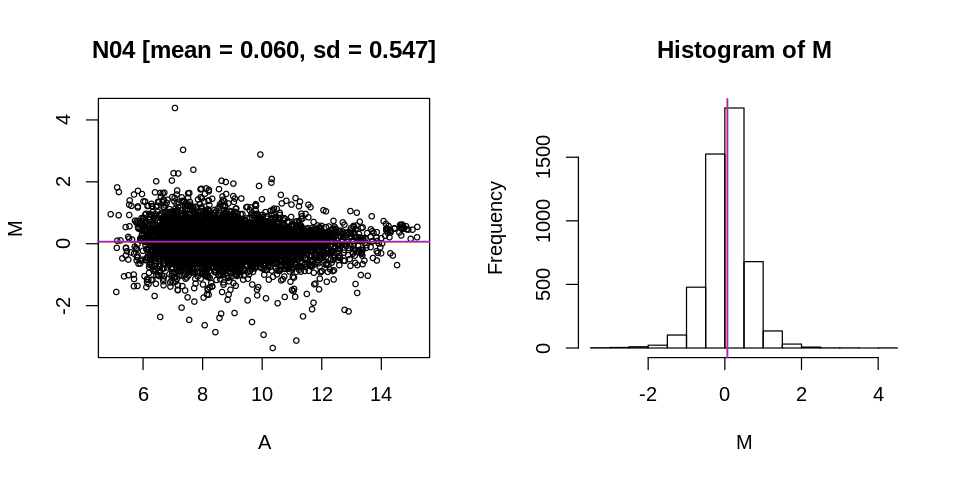

In [368]:
# for (pid in colnames(hypall_norm)[1:76]) {  
#   wpath <- sprintf("~/Dropbox/temp/ma_plot/%s_N01.pdf", pid)
#   pdf(wpath, width = 10, height = 5)
#   plot_ma(hypall_norm[,pid],
#           hypall_norm[,"N01"],
#           title = sprintf("%s", pid))
#   dev.off()
# }

pid <- "N04"
wpath <- sprintf("~/Dropbox/temp/ma_plot/%s_N01.pdf", pid)
# pdf(wpath, width = 10, height = 5)
plot_ma(hypall_norm[,pid], hypall_norm$N01, title = pid)
# dev.off()

In [329]:
## Collate MA plot mean values

# dir.create(sprintf("~/Dropbox/temp/%s", chr))
# wpath <- sprintf("~/Dropbox/temp/%s/%s-%s.pdf", chr, pid, chr)

all_chr <- paste0("chr", 1:22)

raw_mm_tmm_sd <- sapply(
  all_chr,
  function(chr) sapply(
    colnames(hypall_norm)[1:76],
    function(pid) plot_ma(list_chr_all_hyp_norm[[chr]][,pid],
                          list_chr_all_hyp_norm[[chr]][,"N01"])
  )
)
raw_mm_tmm_sd1 <- sapply(
  all_chr,
  function(chr) sapply(
    colnames(hypall_norm)[77:79],
    function(pid) plot_ma(list_chr_all_hyp_norm[[chr]][,pid],
                          list_chr_all_hyp_norm[[chr]][,"N01"])
  )
)

In [343]:
## Collate MA plot mean values

# dir.create(sprintf("~/Dropbox/temp/%s", chr))
# wpath <- sprintf("~/Dropbox/temp/%s/%s-%s.pdf", chr, pid, chr)

all_chr <- paste0("chr", 1:22)

raw_medm_tmm_sd <- sapply(
  all_chr,
  function(chr) sapply(
    colnames(hypall_norm)[1:76],
    function(pid) plot_ma(list_chr_all_hyp_norm[[chr]][,pid],
                          list_chr_all_hyp_norm[[chr]][,"N01"])
  )
)
raw_medm_tmm_sd1 <- sapply(
  all_chr,
  function(chr) sapply(
    colnames(hypall_norm)[77:79],
    function(pid) plot_ma(list_chr_all_hyp_norm[[chr]][,pid],
                          list_chr_all_hyp_norm[[chr]][,"N01"])
  )
)

In [350]:
# plot_chr_hyp(t(raw_mm_tmm_sd[39:76,]), t(raw_mm_tmm_sd1),
#              "~/Dropbox/temp/MM-N01_3.pdf",
#              "~/Dropbox/temp/MM-N01_4.pdf")

plot_chr_hyp(t(raw_medm_tmm_sd[39:76,]), t(raw_medm_tmm_sd1),
             "~/Dropbox/temp/MedM-N01_3.pdf",
             "~/Dropbox/temp/MedM-N01_4.pdf")

### Batch info

In [11]:
hyp_batch <- metadata_df[paste(colnames(hyperdiploid), "D0", sep = "_"), "batch_info"]
names(hyp_batch) <- colnames(hyperdiploid)
print(hyp_batch)

P037 P038 P039 P040 P041 P042 P043 P044 P046 P047 P048 P098 P100 P109 P115 P129 
   1    2    3    3    3    4    4    1    2    2    4    9    9    6    6    9 
P133 P138 P139 P140 P148 P153 P154 P155 P157 P159 P162 P164 P169 P176 P178 P182 
   9    8    8    8    8    9    3    9    9    8    8    7    7    7    8    8 
P183 P189 P195 P196 P207 P208 
   6    6   10   10   10   10 


#### Clustering

In [174]:
## Clustering (T-SNE)
# hyp_tsne <- Rtsne(t(hyperdiploid), perplexity = 1)$Y
# plot(hyp_tsne[,1], hyp_tsne[,2], pch = 19, col = hyp_batch)
# text(hyp_tsne[,1], hyp_tsne[,2], colnames(hyperdiploid))

## Clustering (PCA)
# hyp_pca <- prcomp(t(hyperdiploid))$x
# plot(hyp_pca[,1], hyp_pca[,2], pch = 19, col = hyp_batch)
# text(hyp_pca[,1], hyp_pca[,2], colnames(hyperdiploid))

# # Filtering drug responsive genes
# fltr_hyp1 <- hyperdiploid[hyp_genes,]
# fltr_hyp2 <- hyperdiploid[hyp_wobatch_genes,]
# fltr_hyp_norm1 <- X_hyp[hyp_wobatch_genes,]
# colnames(fltr_hyp2) <- paste(colnames(fltr_hyp2), "D0", sep = "_")

## Clustering with T-SNE does not reveal any pattern

# Clustering (Hierachical)
heatmap_metadata <- metadata_df[, c("batch_info", "label"), drop = F]
pheatmap(fltr_hyp2, col = brewer.pal(9, "Blues"),
       display_numbers = F, fontsize = 5.5,
       legend = T, border_color = "black", scale = "none",
       cluster_method = "ward.D2", cluster_rows = F, cluster_cols = T,
       show_colnames = T, show_rownames = F,
       annotation_col = heatmap_metadata,
       cellwidth = 10, cellheight = 1,
       filename = "~/Dropbox/temp/heatmap-hyp_drug_wobatch.pdf")

# c1_pid <- sprintf("P%03d", c(44, 155, 140, 207, 154, 40, 39, 100, 178))
# c2_pid <- sprintf("P%03d", c(37, 42, 48, 139, 133, 176, 43, 109, 115, 148, 169, 189))
# c3_pid <- sprintf("P%03d", c(41, 46, 47, 38, 153, 162, 164, 159, 183, 129, 138, 208, 195, 196, 157, 98, 182))

# list_clusters <- list(c1_pid, c2_pid, c3_pid)
# list_clusters_all <- convert_list_pid(list_clusters)

## Relapse (gene markers)

In [186]:
# Filtering drug responsive genes
fltr_hypd8 <- hyperdiploid_d8[hyp_wobatch_genes,]
colnames(fltr_hypd8) <- paste(colnames(fltr_hypd8), "D8", sep = "_")

# Clustering (Hierachical)
heatmap_metadata <- metadata_df[, c("batch_info", "label"), drop = F]
pheatmap(fltr_hypd8, col = brewer.pal(9, "Blues"),
       display_numbers = F, fontsize = 5.5,
       legend = T, border_color = "black", scale = "none",
       cluster_method = "ward.D2", cluster_rows = F, cluster_cols = T,
       show_colnames = T, show_rownames = F,
       annotation_col = heatmap_metadata,
       cellwidth = 10, cellheight = 1,
       filename = "~/Dropbox/temp/heatmap-hypd8_drug_wobatch.pdf")

c1_pid1 <- sprintf("P%03d", c(44, 189, 164, 42, 138, 115, 183, 37, 109, 157))
c2_pid1 <- setdiff(colnames(hyperdiploid), c1_pid1)
print(length(c1_pid1))
print(length(c2_pid1))

list_clusters1 <- list(c1_pid1, c2_pid1)
list_clusters_all1 <- convert_list_pid(list_clusters1)

[1] 10
[1] 28


### Plot: Heatmap

#### Relapse marker genes

In [135]:
Y_ord <- Y[order(Y$label),]
Y_annot <- Y[,c("batch_info", "label")] # heatmap annot

## Hyperdiploid D0
hypd0 <- hyperdiploid
colnames(hypd0) <- paste0(colnames(hyperdiploid), "_D0") # rename pid

pid_hypd0 <- rownames(Y_ord)
ord_hypd0 <- hypd0[,pid_hypd0] # rearrange columns
pvalue1 <- calc_ttest(ord_hypd0, size_a = 33, is_paired = F)
ps_relapse <- names(head(sort(pvalue1), 50))

# Plot
filename <- "~/Dropbox/temp/heatmap-hyp_d0.pdf"
pheatmap(ord_hypd0[ps_relapse,],
         annotation_col = Y_annot,
         col = brewer.pal(9, "Blues"),
         display_numbers = F, fontsize = 5.5,
         legend = T, border_color = "black", scale = "none",
         cluster_method = "ward.D2", cluster_rows = T, cluster_cols = T,
         show_colnames = T, show_rownames = T,
         cellwidth = 8, cellheight = 10,
         filename = filename)

#### Plot density plot (chr)

In [ ]:
### DENSITY PLOT ###
## Appending relevant info and converting to long format
t_hyp_normal <- t(hyp_normal1[
  !is.na(ps_chr) & !(ps_chr %in% c("chrX", "chrY")),]) # Filter out unassigned ps
batch_idx <- metadata_df[paste(rownames(t_hyp_normal), "D0", sep = "_"), "batch_info"]
batch_idx[is.na(batch_idx)] <- "Normal"
batch_hyp_normal <- data.frame(pid = rownames(t_hyp_normal),
                               batch = as.factor(batch_idx),
                               t_hyp_normal,
                               check.names = F)
long_hyp_normal <- melt(batch_hyp_normal,
                        id.vars = c("pid", "batch"),
                        variable.name = "probeset")
long_hyp_normal$chr <- ps_chr[as.character(long_hyp_normal$probeset)]
ps_density <- ggplot(long_hyp_normal) +
  geom_density(aes(x = value, group = pid, colour = batch)) +
  facet_wrap(~chr, nrow = 4, ncol = 6)
ggsave("~/Dropbox/temp/ps_density-fltr70.pdf", ps_density,
       width = 12, height = 8)

## Ideas

#### Hyperdiploid (D8)
Hypothesis: Clonal evolution

In [194]:
list_chr_hypd8 <- split.data.frame(hyperdiploid_d8, ps_chr)
## MEDIAN
hypd8_median <- t(sapply(list_chr_hypd8, apply, 2, median))[1:22,]

## Filter genes
fltrdb_norm <- normal[hyp_wobatch_genes,]
fltrdb_hypd8 <- hyperdiploid_d8[hyp_wobatch_genes,]
## Chr annotation
ps_chr2 <- get_chrloc(hyp_wobatch_genes, annot)

### NORMAL
list_chr_fltrdb_norm <- split.data.frame(fltrdb_norm, ps_chr2)
## MEDIAN
fltrdb_norm_median <- t(sapply(list_chr_fltrdb_norm, apply, 2, median))[1:22,]

### HYPERDIPLOID
list_chr_fltrdb_hypd8 <- split.data.frame(fltrdb_hypd8, ps_chr2)
## MEDIAN
fltrdb_hypd8_median <- t(sapply(list_chr_fltrdb_hypd8, apply, 2, median))[1:22,]

#### Hyperdiploid (D33)

In [112]:
list_chr_hypd33 <- split.data.frame(hyperdiploid_d33, ps_chr)
## MEDIAN
hypd33_median <- t(sapply(list_chr_hypd33, apply, 2, median))[1:22,]

#### Drug responsive genes (hyperdiploid)

In [151]:
## Filter genes
fltr_norm <- normal[hyp_wobatch_genes,]
fltr_hyp <- hyperdiploid[hyp_wobatch_genes,]
## Chr annotation
ps_chr2 <- get_chrloc(hyp_wobatch_genes, annot)

### NORMAL
list_chr_norm2 <- split.data.frame(fltr_norm, ps_chr2)
## MEDIAN
norm_median2 <- t(sapply(list_chr_norm, apply, 2, median))[1:22,]

### HYPERDIPLOID
list_chr_hyp2 <- split.data.frame(fltr_hyp, ps_chr2)
## MEDIAN
hyp_median2 <- t(sapply(list_chr_hyp, apply, 2, median))[1:22,]

#### ComBat

In [138]:
### ComBat
### NORMAL
list_chr_norm_combat <- split.data.frame(norm_combat, ps_chr)
## MEDIAN
norm_combat_median <- t(sapply(list_chr_norm_combat, apply, 2, median))[1:22,]
### HYPERDIPLOID
list_chr_hyp_combat <- split.data.frame(hyp_combat, ps_chr)
## MEDIAN
hyp_combat_median <- t(sapply(list_chr_hyp_combat, apply, 2, median))[1:22,]

#### Investigate individual top probesets

In [371]:
pid_hypd0d8 <- rownames(Y)[Y$subtype == "Hyperdiploid"]

# Calculate pairwise logfc
logfc <- hyperdiploid - hyperdiploid_d8
top50_down <- apply(logfc, 2, function(x) names(head(sort(x), 50)))
top50_up <- apply(logfc, 2, function(x) names(head(sort(-x), 50)))
top50_down <- as.list(data.frame(top50_down, stringsAsFactors = F))
top50_up <- as.list(data.frame(top50_up, stringsAsFactors = F))

In [376]:
all_top50_down <- do.call(c, top50_down)
all_top50_up <- do.call(c, top50_up)

In [615]:
## logfc -> clustering
## Filter probesets that occur frequently in up and down regulated genes
FREQ_PS <- 10
freq_down <- table(all_top50_down)
ps_down <- names(freq_down[freq_down > FREQ_PS])

FREQ_PS <- 10
freq_up <- table(all_top50_up)
ps_up <- names(freq_up[freq_up > FREQ_PS])

In [677]:
## Up and down regulated probesets
X <- hyperdiploid[c(ps_down, ps_up),]
pca_obj <- prcomp(t(X))
X_pca <- pca_obj$x

relapse_pid <- c("P038", "P115", "P129", "P164", "P189")
col <- ifelse(colnames(X) %in% relapse_pid, "red", "black")

pdf("~/Dropbox/temp/pca-top50updown.pdf", width = 10, height = 6)
plot(X_pca[,1:2])
text(X_pca[,1:2], colnames(X), col = col)
dev.off()

# ## Log-fc
# X <- logfc
# pca_obj <- prcomp(t(X))
# X_pca <- pca_obj$x

# relapse_pid <- c("P038", "P115", "P129", "P164", "P189")
# col <- ifelse(colnames(X) %in% relapse_pid, "red", "black")

# pdf("~/Dropbox/temp/pca-logfc.pdf", width = 10, height = 6)
# plot(X_pca[,1:2], col = "white")
# text(X_pca[,1:2], colnames(X), cex = .7, col = col)
# dev.off()

png 
  2

In [ ]:
# # Heatmap
# pheatmap(hypall_norm[c(ps_down, ps_up),],
#          col = brewer.pal(9, "Blues"),
#          display_numbers = F, fontsize = 5.5,
#          legend = T, border_color = "black", scale = "none",
#          cluster_method = "ward.D2", cluster_rows = F, cluster_cols = T,
#          show_colnames = T, show_rownames = F,
#          annotation_col = metadata_df,
#          cellwidth = 5, cellheight = 5)

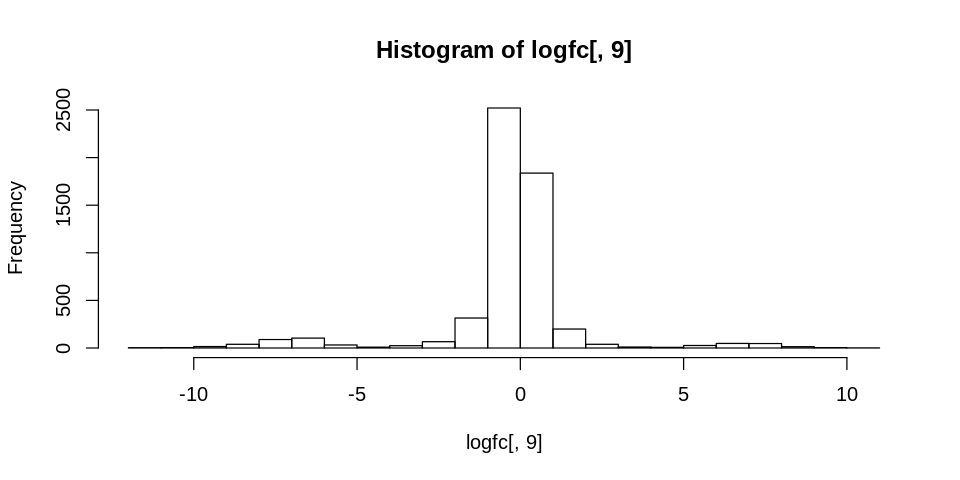

In [406]:
hist(logfc[,9], breaks = 20)

#### Plot graph with (V: Patients, E: Probesests)

In [598]:
## Create adjacency matrix (weight is number of shared ps)
adj_down <- sapply(top50_down,
                   function(x) sapply(top50_down,
                                      function(y) length(intersect(x, y))))
adj_up <- sapply(top50_up,
                 function(x) sapply(top50_up,
                                    function(y) length(intersect(x, y))))

In [698]:
## Spectral clustering
A_down <- adj_down
# A_up <- adj_up
A <- A_down/50 # Normalised similarity matrix

# epsilon-distance graph
THRESHOLD <- 0.2
A[A < THRESHOLD] <- 0
print(A)

     P037 P038 P039 P040 P041 P042 P043 P044 P046 P047 P048 P098 P100 P109 P115
P037 1.00 0.00    0    0    0 0.26 0.00    0 0.00 0.00 0.00 0.00    0    0 0.00
P038 0.00 1.00    0    0    0 0.20 0.20    0 0.22 0.00 0.00 0.00    0    0 0.00
P039 0.00 0.00    1    0    0 0.00 0.00    0 0.00 0.00 0.00 0.00    0    0 0.00
P040 0.00 0.00    0    1    0 0.00 0.00    0 0.00 0.00 0.00 0.00    0    0 0.00
P041 0.00 0.00    0    0    1 0.00 0.00    0 0.00 0.00 0.00 0.00    0    0 0.00
P042 0.26 0.20    0    0    0 1.00 0.26    0 0.30 0.00 0.20 0.00    0    0 0.30
P043 0.00 0.20    0    0    0 0.26 1.00    0 0.20 0.00 0.00 0.00    0    0 0.26
P044 0.00 0.00    0    0    0 0.00 0.00    1 0.00 0.00 0.00 0.00    0    0 0.00
P046 0.00 0.22    0    0    0 0.30 0.20    0 1.00 0.26 0.28 0.20    0    0 0.30
P047 0.00 0.00    0    0    0 0.00 0.00    0 0.26 1.00 0.20 0.00    0    0 0.00
P048 0.00 0.00    0    0    0 0.20 0.00    0 0.28 0.20 1.00 0.00    0    0 0.00
P098 0.00 0.00    0    0    0 0.00 0.00 

In [699]:
G <- graph_from_adjacency_matrix(A, mode = "undirected",
                                 weighted = TRUE, diag = FALSE)
# edge_attr_names(G)
relapse_pid <- c("P038", "P115", "P129", "P164", "P189")
col <- ifelse(rownames(A) %in% relapse_pid, "lightsalmon", "olivedrab2")
V(G)$color <- col

pdf("~/Dropbox/temp/graph-top50_down1.pdf",
    width = 12, height = 12)
plot(G, vertex.size = 10, vertex.label.cex = 1, edge.width = E(G)$weight*10)
dev.off()

png 
  2

#### Spectral clustering

In [538]:
## Spectral clustering
adj <- raw_adj
A <- adj/50 # Normalised similarity matrix

# epsilon-distance graph
THRESHOLD <- 0.2
A[A < THRESHOLD] <- 0

In [549]:
D <- diag(apply(A, 1, sum)) # degree matrix

# Un-normalised laplacian
U <- D - A 

# Normalized Laplacian
"%^%" <- function(M, power)
  with(eigen(M), vectors %*% (values^power * solve(vectors)))
L <- (D %^% (-1/2)) %*% A %*% (D %^% (-1/2))

# Eigendecomposition
evL <- eigen(U, symmetric=TRUE)
Z <- evL$vectors
k <- 2
Z_small <- evL$vectors[,(ncol(evL$vectors)-k+1):ncol(evL$vectors)]

In [469]:
g <- graph_from_adjacency_matrix(adj, mode = "undirected", weighted = TRUE)
pdf("~/Dropbox/temp/graph.pdf")
plot(g, layout = layout_in_circle, vertex.size = 7, vertex.label.cex = .5)
dev.off()

png 
  2

## Batch effect correction (gene level)

In [133]:
##### BATCH EFFECT CORRECTION #####
### ComBat
# Obtaining batch information of selected_yeoh df
# Rows of metadata are to be in same order as columns of edata
batch <- as.factor(metadata_df[colnames(data_yeoh), "batch_info"])
timepoint <- as.factor(metadata_df[colnames(data_yeoh), "class_info"])
# Covariates (subtype, label) are confounded
yeoh_metadata <- data.frame(batch, timepoint)

# Place adjustment/confounding variables in model.matrix (e.g. age)
# Do not put batch variables in model.matrix
## Put batch variables directly in combat function!
# OPTION: Include biological variable of interest as covariate
# model_combat <- model.matrix(~1, data = yeoh_metadata)
model_combat <- model.matrix(~timepoint, data = yeoh_metadata)
combat_yeoh <- ComBat(data.matrix(data_yeoh), batch, model_combat)
# Replacing negative values with 0
combat_yeoh[combat_yeoh < 0] <- 0

## Normal
idx_normal <- metadata_df[colnames(data_yeoh), "subtype"] == "Normal"
norm_combat <- combat_yeoh[,idx_normal]

## Hyperdiploid
idx_hyp <- metadata_df[colnames(data_yeoh), "subtype"] == "Hyperdiploid" &
  metadata_df[colnames(data_yeoh), "class_info"] == "D0"
hyp_combat <- combat_yeoh[,idx_hyp]
colnames(hyp_combat) <- substring(colnames(hyp_combat), 1, 4)

Found9batches
Adjusting for2covariate(s) or covariate level(s)


Standardizing Data across genes


Fitting L/S model and finding priors
Finding parametric adjustments
Adjusting the Data



### Investigate: Hyperdiploid

In [312]:
#' @param x vector
#' @param y vector
#' @param return matrix of n+2 interpolations (features x samples)
interpolate <- function(x, y, n) {
  stopifnot(length(x) == length(y))
  
  m <- n + 1
  sapply(0:m,
         function(i, x, y) (m-i)/m * x + i/m * y,
         x, y)
}

#' Calculates outer product of columns in two dataframes
#' For each pair of columns returns a set of interpolated points
#' If subsampling, unsampled original points will also be returned
#' along with simulated data
#' @param X dataframe with features x samples
#' @param Y dataframe with features x samples
#' @param f function to perform on the 2-tuple
#' @param n number of interpolations
#' @return dataframe
outer_prod <- function(X, Y, n = 3, n_subsample = 0) {
  if (n_subsample == 0) {
      mat <- do.call(
        cbind,
        lapply(
          X,
          function(x) do.call(cbind, lapply(Y, function(y) interpolate(x, y, n)))
        )
      )

    siml_names <- as.vector(t(outer(colnames(X), colnames(Y), paste, sep = "_")))
    siml_names1 <- paste(rep(siml_names, each = n + 2), 1:(n+2), sep = "_")

    V <- data.frame(mat)
    colnames(V) <- siml_names1
    rownames(V) <- rownames(X)
    return(V)
  
  } else {
    n_x <- ncol(X)
    n_y <- ncol(Y)
    idx_x <- sample(1:n_x, n_subsample)
    idx_y <- sample(1:n_y, n_subsample)
    X_unsampled <- X[, -idx_x, drop = F]
    Y_unsampled <- Y[, -idx_y, drop = F]
    
    mat <- do.call(
      cbind,
      lapply(
        X[, idx_x, drop = F],
        function(x) do.call(cbind, lapply(
          Y[, idx_y, drop = F],
          function(y) interpolate(x, y, n)
        ))
      )
    )
    
    siml_names <- as.vector(t(outer(
      colnames(X[, idx_x, drop = F]),
      colnames(Y[, idx_y, drop = F]),
      paste,
      sep = "_"
    )))
    siml_names1 <- paste(rep(siml_names, each = n + 2),
                         1:(n + 2),
                         sep = "_")

    V <- data.frame(mat, X_unsampled, Y_unsampled)
    colnames(V) <- c(siml_names1,
                     colnames(X_unsampled),
                     colnames(Y_unsampled))
    rownames(V) <- rownames(X)
    return(V)
    
  }
}

In [293]:
#' PCA space is defined using Yeoh (D0) data and rest of the datapoints are projected
#' @param X dataframe with features x samples and containing
#' D0, D8 and 3 Normal patients (ordered correctly)
#' @param metadata_df metadata (need not be aligned with X)
plot_vectors_d0 <- function(X_d0, X_d8, X_siml, metadata_df,
                            cex = 3, n_pc = 3, main = NULL) {
  pca_obj <- prcomp(t(X_d0))
  d0_pca <- data.frame(pca_obj$x[,1:n_pc])
  
  d8_pca <- data.frame(predict(pca_obj, t(X_d8))[,1:n_pc])
  siml_pca <- data.frame(predict(pca_obj, t(X_siml))[,1:n_pc])

  stopifnot(all(substring(rownames(d0_pca), 1, 4) == substring(rownames(d8_pca), 1, 4)))

  subtype_pca <- cbind(d0_pca, d8_pca)
  colnames(subtype_pca) <- c(
    paste(colnames(subtype_pca)[1:n_pc], "A", sep = "_"),
    paste(colnames(subtype_pca)[(n_pc+1):(n_pc*2)], "B", sep = "_")
  )

  # Obtaining batch and class annotations
  label <- as.numeric(metadata_df[rownames(d0_pca), "label"]) + 1
  batch <- as.factor(metadata_df[rownames(d0_pca), "batch_info"])

  # Axis labels
  eigenvalues <- (pca_obj$sdev)^2
  var_pc <- eigenvalues[1:n_pc]/sum(eigenvalues)
  pc_labels <- sprintf("PC%d (%.2f%%)", 1:n_pc, var_pc * 100)
  
  scatter_pca <- ggplot(data = subtype_pca) +
    geom_point(aes(x = PC1_A, y = PC2_A, colour = batch), shape = 15,
               size = cex, show.legend = F) +
    geom_point(aes(x = PC1_B, y = PC2_B, colour = batch), shape = 16,
               size = cex, show.legend = F) +
    geom_segment(aes(x = PC1_A, y = PC2_A, xend = PC1_B, yend = PC2_B),
                 arrow = arrow(length = unit(0.3, "cm")),
                 alpha = 0.5, colour = label) +
#     geom_text(aes(x = PC1_A, y = PC2_A,
#                   label = rownames(subtype_pca)),
#               position = position_nudge(x = 4, y = 2), size = 2.5) +
#     geom_point(data = norm_pca, aes(x = PC1, y = PC2),
#                size = cex, shape = 17, col = "red") +
    geom_point(data = siml_pca, aes(x = PC1, y = PC2, shape = subtype),
               size = cex, alpha = 0.3, col = "darkblue", show.legend = F) +
    xlab(pc_labels[1]) + ylab(pc_labels[2])
  
  return(scatter_pca)
}

In [294]:
SUBTYPE <- "Hyperdiploid"
pid_subtype <- rownames(Y)[Y$subtype == SUBTYPE]
pid_normal <- rownames(Y)[Y$subtype == "Normal"]
drug_genes <- getLocalGenes(data[,pid_subtype], pid_remission)
db_genes <- setdiff(drug_genes, batch_genes)

normal <- data[db_genes, Y$subtype == "Normal"]
idx_d0 <- Y$class_info == "D0" & Y$subtype == SUBTYPE
idx_d8 <- Y$class_info == "D8" & Y$subtype == SUBTYPE
X_d0 <- data[db_genes, idx_d0, drop = F]
X_d8 <- data[db_genes, idx_d8, drop = F]
X_siml <- outer_prod(X_d0, normal, n = 3)

ax_vectors <- plot_vectors_d0(X_d0, X_d8, X_siml, Y)
wpath <- sprintf("~/Dropbox/temp/vectors_pca_d0_siml-%s.pdf", SUBTYPE)
ggsave(wpath, ax_vectors, width = 10, height = 5)

[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 715"
[1] "No. of features (p-value) = 2592"
[1] "No. of features (log2-fc) = 285"


### Investigate: TEL-AML1

In [272]:
#' Plot vectors 2D
#' @param X dataframe with features x samples and containing
#' @param wrong_labels relapse remission and rem (bad prediction) labels
#' D0, D8 and 3 Normal patients (ordered correctly)
eval_vectors <- function(X, metadata_df, cex = 3, wrong_labels,
                         pc_labels = NULL, main = NULL) {
  # PCA
  pca_obj <- prcomp(t(X))
  pca_df <- data.frame(pca_obj$x[,1:2])
  n <- nrow(pca_df)
  d0_pca <- pca_df[1:((n-3)/2),]
  d8_pca <- pca_df[((n-1)/2):(n-3),]

  stopifnot(all(substring(rownames(d0_pca), 1, 4) == substring(rownames(d8_pca), 1, 4)))

  subtype_pca <- cbind(d0_pca, d8_pca)
  colnames(subtype_pca) <- c("PC1_A", "PC2_A", "PC1_B", "PC2_B")
  norm_pca <- pca_df[(n-2):n,]

  # Obtaining batch and class annotations
  batch <- as.factor(metadata_df[rownames(d8_pca), "batch_info"])
  pred_label <- wrong_labels[rownames(d8_pca), "label"]
  print(pred_label)

  # Axis labels
  eigenvalues <- (pca_obj$sdev)^2
  var_pc <- eigenvalues[1:4]/sum(eigenvalues)
  pc_labels <- sprintf("PC%d (%.2f%%)", 1:4, var_pc*100)
  
  scatter_pca <- ggplot(data = subtype_pca) +
    geom_point(aes(x = PC1_A, y = PC2_A, fill = batch), shape = 21,
               size = cex, show.legend = T) +
    geom_point(aes(x = PC1_B, y = PC2_B, fill = batch), shape = 22,
               size = cex, show.legend = F) +
    geom_segment(aes(x = PC1_A, y = PC2_A, xend = PC1_B, yend = PC2_B, colour = pred_label),
                 arrow = arrow(length = unit(0.3, "cm")),
                 alpha = 0.6) +
#     geom_text(aes(x = PC1_A, y = PC2_A,
#                   label = rownames(subtype_pca)),
#               position = position_nudge(x = 4, y = 2), size = 2.5) +
    geom_point(data = norm_pca, aes(x = PC1, y = PC2),
               size = cex, shape = 23, fill = "black") +
    xlab(pc_labels[1]) + ylab(pc_labels[2]) +
    scale_color_manual(values = c("tomato3", "darkolivegreen3", "purple"))
  
  if (!is.null(main)) {
    scatter_pca <- scatter_pca + labs(title = main)
  }
  
  return(scatter_pca)
}

In [274]:
#' @param risk df from predict_relapse function that contains
#' label and risk of relapse prediction
#' @returns dataframe with one factor column containing levels of
#' relapse, remission, wrong prediction
classify_bad_prediction <- function(risk) {
  relapse_min_risk <- min(risk[risk$label == 1, "risk_relapse"])
  wrong_pred <- risk[, "label", drop = F]
  wrong_pred$label <- ifelse(wrong_pred$label == 0, "remission", "relapse")
  idx_remission_wrong <- risk$label == 0 & risk$risk_relapse > relapse_min_risk
  wrong_pred[idx_remission_wrong, "label"] <- "wrong prediction"
  return(wrong_pred)
}

subtype <- "TEL-AML1"
print(subtype)
pid_subtype <- rownames(Y)[Y$subtype == subtype]
pred_obj <- predict_relapse(pid_subtype, data, pid_remission, Y,
                        batch_genes = batch_genes)
pred_labels <- classify_bad_prediction(pred_obj[[1]])
eval_plot <- eval_vectors(pred_obj[[2]], Y, wrong_labels = pred_labels)
wpath <- "~/Dropbox/temp/eval_vectors-TEL-AML1.pdf"
ggsave(wpath, eval_plot, width = 12, height = 6)

[1] "TEL-AML1"
[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 743"
[1] "No. of features (p-value) = 2818"
[1] "No. of features (log2-fc) = 521"
[1] "No. of selected genes = " "519"                     
[1] "No. of final genes = " "382"                  
 [1] "P013_D0" "P014_D0" "P015_D0" "P016_D0" "P017_D0" "P018_D0" "P019_D0"
 [8] "P020_D0" "P022_D0" "P023_D0" "P024_D0" "P025_D0" "P026_D0" "P027_D0"
[15] "P028_D0" "P029_D0" "P031_D0" "P032_D0" "P033_D0" "P034_D0" "P035_D0"
[22] "P036_D0" "P094_D0" "P096_D0" "P099_D0" "P106_D0" "P117_D0" "P120_D0"
[29] "P121_D0" "P127_D0" "P135_D0" "P136_D0" "P147_D0" "P156_D0" "P165_D0"
[36] "P166_D0" "P172_D0" "P185_D0" "P188_D0" "P013_D8" "P014_D8" "P015_D8"
[43] "P016_D8" "P017_D8" "P018_D8" "P019_D8" "P020_D8" "P022_D8" "P023_D8"
[50] "P024_D8" "P025_D8" "P026_D8" "P027_D8" "P028_D8" "P029_D8" "P031_D8"
[57] "P032_D8" "P033_D8" "P034_D8" "P035_D8" "P036_D8" "P094_D8" "P096_D8"
[64] "P099_D8" "P106_D8" "P11

Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 5 rows containing missing values (geom_path).”Warning message:
“Removed 5 rows containing missing values (geom_point).”

 [1] "remission"        "remission"        "wrong prediction" "wrong prediction"
 [5] "remission"        "wrong prediction" "relapse"          "remission"       
 [9] "wrong prediction" "wrong prediction" "remission"        "remission"       
[13] "wrong prediction" "remission"        "wrong prediction" "relapse"         
[17] "remission"        "wrong prediction" "remission"        "relapse"         
[21] "remission"        "wrong prediction" "relapse"          "relapse"         
[25] "remission"        "remission"        "remission"        "remission"       
[29] "remission"        "remission"        "remission"        "relapse"         
[33] "remission"        "remission"        "remission"        "remission"       
[37] "remission"        "remission"        "remission"       


Factors of variation: Timepoint, batch, subtype, remission

### Marker genes

In [160]:
marker_genes <- c("EBF1", "IKZF1", "MSH6", "BTG1", "NR3C1",
                   "CDKN2A", "CDKN2B", "PAX5", "ETV6")
subset_marker_genes <- marker_genes[marker_genes %in% rownames(ahypall_norm)]
# fltrmg_ahypall_norm <- ahypall_norm[subset_marker_genes,] # marker genes
fltrmg_aall_hyp_norm <- aall_hyp_norm[subset_marker_genes,] # marker genes

#### Prediction (chr median): ERM3 (PC2)

In [569]:
## Prediction (all subtypes)
all_subtypes <- levels(metadata_df$subtype)
subtypes <- setdiff(all_subtypes, c("Hypodiploid", "Normal"))
subtype_factor <- metadata_df[colnames(all_median), "subtype", drop = F]
for (subtype in subtypes) {
  subtype_pid <- rownames(subtype_factor)[subtype_factor == subtype]
  pid_norm <- paste0("N0", c(1,2,4))
  pid <- c(subtype_pid, pid_norm)
  wpath <- sprintf("~/Dropbox/temp/prediction_chr_median_pc2-%s.pdf", subtype)
  predict_relapse_pca(all_median[,pid], wpath = wpath)
}

[1] "No. of PCs: 5"
[1] "N01" "N02" "N04"


Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 1 rows containing missing values (geom_path).”

[1] "No. of PCs: 2"
[1] "N01" "N02" "N04"


Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 1 rows containing missing values (geom_point).”

[1] "No. of PCs: 7"
[1] "N01" "N02" "N04"


Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 3 rows containing missing values (geom_path).”Warning message:
“Removed 3 rows containing missing values (geom_point).”

[1] "No. of PCs: 2"
[1] "N01" "N02" "N04"


Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 1 rows containing missing values (geom_point).”

[1] "No. of PCs: 4"
[1] "N01" "N02" "N04"


Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 2 rows containing missing values (geom_path).”Warning message:
“Removed 2 rows containing missing values (geom_point).”

[1] "No. of PCs: 5"
[1] "N01" "N02" "N04"


Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 3 rows containing missing values (geom_path).”Warning message:
“Removed 3 rows containing missing values (geom_point).”

[1] "No. of PCs: 5"
[1] "N01" "N02" "N04"


Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 5 rows containing missing values (geom_path).”Warning message:
“Removed 5 rows containing missing values (geom_point).”

#### Prediction (chr median)

In [450]:
pid_remission <- rownames(metadata_df)[metadata_df$label == 0]
pid_allhyp <- convert_list_pid(list(colnames(hyperdiploid)))[[1]]
print(pid_allhyp)

list_prediction <- predict_relapse(pid_allhyp, hypall_norm_median, pid_remission,
                                   class_genes = rownames(hypall_norm_median))

ERROR: Error in convert_list_pid(list(colnames(hyperdiploid))): could not find function "convert_list_pid"


#### Predict all subtypes (chr median)

In [494]:
# Factor to split data
subtypes_yeoh <- splitSubtype(all_median, metadata_df)

all_subtypes <- levels(metadata_df$subtype)
subtypes <- setdiff(all_subtypes, c("Hypodiploid", "Normal"))
pid_remission <- rownames(metadata_df)[metadata_df$label == 0]
# list_drug_genes <- list()
for (subtype in subtypes) {
  pid_subtype <- colnames(subtypes_yeoh[[subtype]])
  wpath <- sprintf("~/Dropbox/temp/prediction_chr_median-%s.pdf", subtype)
  predict_relapse(pid_subtype, all_median, pid_remission, 
                  class_genes = rownames(all_median), wpath = wpath)
}

# # Save list of drug responsive genes
# names(list_drug_genes) <- subtypes
# saveRDS(list_drug_genes, "temp/list_drug_genes.rds")

[1] "No. of selected genes = " "22"                      
[1] "No. of final genes = " "22"                   
 [1] "P053_D0" "P054_D0" "P055_D0" "P056_D0" "P057_D0" "P134_D0" "P152_D0"
 [8] "P170_D0" "P175_D0" "P184_D0" "P053_D8" "P054_D8" "P055_D8" "P056_D8"
[15] "P057_D8" "P134_D8" "P152_D8" "P170_D8" "P175_D8" "P184_D8"
 [1] "P053_D0" "P054_D0" "P055_D0" "P056_D0" "P057_D0" "P134_D0" "P152_D0"
 [8] "P170_D0" "P175_D0" "P184_D0" "P053_D8" "P054_D8" "P055_D8" "P056_D8"
[15] "P057_D8" "P134_D8" "P152_D8" "P170_D8" "P175_D8" "P184_D8"
[1] "N01" "N02" "N04"


Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 1 rows containing missing values (geom_path).”

[1] "No. of selected genes = " "22"                      
[1] "No. of final genes = " "22"                   
 [1] "P049_D0" "P050_D0" "P051_D0" "P102_D0" "P124_D0" "P145_D0" "P161_D0"
 [8] "P049_D8" "P050_D8" "P051_D8" "P102_D8" "P124_D8" "P145_D8" "P161_D8"
 [1] "P049_D0" "P050_D0" "P051_D0" "P102_D0" "P124_D0" "P145_D0" "P161_D0"
 [8] "P049_D8" "P050_D8" "P051_D8" "P102_D8" "P124_D8" "P145_D8" "P161_D8"
[1] "N01" "N02" "N04"


Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 1 rows containing missing values (geom_point).”

[1] "No. of selected genes = " "22"                      
[1] "No. of final genes = " "22"                   
 [1] "P037_D0" "P038_D0" "P039_D0" "P040_D0" "P041_D0" "P042_D0" "P043_D0"
 [8] "P044_D0" "P046_D0" "P047_D0" "P048_D0" "P098_D0" "P100_D0" "P109_D0"
[15] "P115_D0" "P129_D0" "P133_D0" "P138_D0" "P139_D0" "P140_D0" "P148_D0"
[22] "P153_D0" "P154_D0" "P155_D0" "P157_D0" "P159_D0" "P162_D0" "P164_D0"
[29] "P169_D0" "P176_D0" "P178_D0" "P182_D0" "P183_D0" "P189_D0" "P195_D0"
[36] "P196_D0" "P207_D0" "P208_D0" "P037_D8" "P038_D8" "P039_D8" "P040_D8"
[43] "P041_D8" "P042_D8" "P043_D8" "P044_D8" "P046_D8" "P047_D8" "P048_D8"
[50] "P098_D8" "P100_D8" "P109_D8" "P115_D8" "P129_D8" "P133_D8" "P138_D8"
[57] "P139_D8" "P140_D8" "P148_D8" "P153_D8" "P154_D8" "P155_D8" "P157_D8"
[64] "P159_D8" "P162_D8" "P164_D8" "P169_D8" "P176_D8" "P178_D8" "P182_D8"
[71] "P183_D8" "P189_D8" "P195_D8" "P196_D8" "P207_D8" "P208_D8"
 [1] "P037_D0" "P038_D0" "P039_D0" "P040_D0" "P041_D0" "P042_D0" "P043_D0"


Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 3 rows containing missing values (geom_path).”Warning message:
“Removed 3 rows containing missing values (geom_point).”

[1] "No. of selected genes = " "22"                      
[1] "No. of final genes = " "22"                   
 [1] "P058_D0" "P122_D0" "P131_D0" "P137_D0" "P146_D0" "P160_D0" "P167_D0"
 [8] "P211_D0" "P058_D8" "P122_D8" "P131_D8" "P137_D8" "P146_D8" "P160_D8"
[15] "P167_D8" "P211_D8"
 [1] "P058_D0" "P122_D0" "P131_D0" "P137_D0" "P146_D0" "P160_D0" "P167_D0"
 [8] "P211_D0" "P058_D8" "P122_D8" "P131_D8" "P137_D8" "P146_D8" "P160_D8"
[15] "P167_D8" "P211_D8"
[1] "N01" "N02" "N04"


Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 1 rows containing missing values (geom_point).”

[1] "No. of selected genes = " "22"                      
[1] "No. of final genes = " "22"                   
  [1] "P059_D0" "P060_D0" "P061_D0" "P062_D0" "P063_D0" "P064_D0" "P065_D0"
  [8] "P066_D0" "P067_D0" "P068_D0" "P070_D0" "P071_D0" "P072_D0" "P073_D0"
 [15] "P075_D0" "P076_D0" "P077_D0" "P078_D0" "P080_D0" "P081_D0" "P082_D0"
 [22] "P083_D0" "P084_D0" "P085_D0" "P086_D0" "P087_D0" "P089_D0" "P090_D0"
 [29] "P091_D0" "P092_D0" "P093_D0" "P095_D0" "P097_D0" "P101_D0" "P104_D0"
 [36] "P105_D0" "P108_D0" "P111_D0" "P119_D0" "P123_D0" "P125_D0" "P126_D0"
 [43] "P128_D0" "P130_D0" "P132_D0" "P141_D0" "P142_D0" "P143_D0" "P144_D0"
 [50] "P149_D0" "P150_D0" "P158_D0" "P163_D0" "P171_D0" "P173_D0" "P174_D0"
 [57] "P177_D0" "P179_D0" "P180_D0" "P181_D0" "P187_D0" "P191_D0" "P192_D0"
 [64] "P193_D0" "P194_D0" "P197_D0" "P199_D0" "P200_D0" "P201_D0" "P202_D0"
 [71] "P203_D0" "P204_D0" "P205_D0" "P206_D0" "P209_D0" "P210_D0" "P212_D0"
 [78] "P213_D0" "P214_D0" "P215_D0" "P216_D0" "P217_D0

Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 2 rows containing missing values (geom_path).”Warning message:
“Removed 2 rows containing missing values (geom_point).”

[1] "No. of selected genes = " "22"                      
[1] "No. of final genes = " "22"                   
 [1] "P001_D0" "P004_D0" "P005_D0" "P007_D0" "P008_D0" "P009_D0" "P010_D0"
 [8] "P011_D0" "P012_D0" "P103_D0" "P116_D0" "P151_D0" "P190_D0" "P001_D8"
[15] "P004_D8" "P005_D8" "P007_D8" "P008_D8" "P009_D8" "P010_D8" "P011_D8"
[22] "P012_D8" "P103_D8" "P116_D8" "P151_D8" "P190_D8"
 [1] "P001_D0" "P004_D0" "P005_D0" "P007_D0" "P008_D0" "P009_D0" "P010_D0"
 [8] "P011_D0" "P012_D0" "P103_D0" "P116_D0" "P151_D0" "P190_D0" "P001_D8"
[15] "P004_D8" "P005_D8" "P007_D8" "P008_D8" "P009_D8" "P010_D8" "P011_D8"
[22] "P012_D8" "P103_D8" "P116_D8" "P151_D8" "P190_D8"
[1] "N01" "N02" "N04"


Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 3 rows containing missing values (geom_path).”Warning message:
“Removed 3 rows containing missing values (geom_point).”

[1] "No. of selected genes = " "22"                      
[1] "No. of final genes = " "22"                   
 [1] "P013_D0" "P014_D0" "P015_D0" "P016_D0" "P017_D0" "P018_D0" "P019_D0"
 [8] "P020_D0" "P022_D0" "P023_D0" "P024_D0" "P025_D0" "P026_D0" "P027_D0"
[15] "P028_D0" "P029_D0" "P031_D0" "P032_D0" "P033_D0" "P034_D0" "P035_D0"
[22] "P036_D0" "P094_D0" "P096_D0" "P099_D0" "P106_D0" "P117_D0" "P120_D0"
[29] "P121_D0" "P127_D0" "P135_D0" "P136_D0" "P147_D0" "P156_D0" "P165_D0"
[36] "P166_D0" "P172_D0" "P185_D0" "P188_D0" "P013_D8" "P014_D8" "P015_D8"
[43] "P016_D8" "P017_D8" "P018_D8" "P019_D8" "P020_D8" "P022_D8" "P023_D8"
[50] "P024_D8" "P025_D8" "P026_D8" "P027_D8" "P028_D8" "P029_D8" "P031_D8"
[57] "P032_D8" "P033_D8" "P034_D8" "P035_D8" "P036_D8" "P094_D8" "P096_D8"
[64] "P099_D8" "P106_D8" "P117_D8" "P120_D8" "P121_D8" "P127_D8" "P135_D8"
[71] "P136_D8" "P147_D8" "P156_D8" "P165_D8" "P166_D8" "P172_D8" "P185_D8"
[78] "P188_D8"
 [1] "P013_D0" "P014_D0" "P015_D0" "P016_D0" "P017

Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 5 rows containing missing values (geom_path).”Warning message:
“Removed 5 rows containing missing values (geom_point).”

#### Prediction (marker genes)

In [404]:
# pid_remission <- rownames(metadata_df)[metadata_df$label == 0]
# n_hypall <- ncol(fltrmg_ahypall_norm)
# pid_hypall <- colnames(fltrmg_ahypall_norm)[-((n_hypall-2):n_hypall)]

predict_relapse(pid_hypall, fltrmg_ahypall_norm, pid_remission,
                class_genes = rownames(fltrmg_ahypall_norm),
                wpath = "~/Dropbox/temp/prediction.pdf")

[1] "No. of selected genes = " "4"                       
[1] "No. of final genes = " "4"                    
[1] "N01" "N02" "N04"


Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 1 rows containing missing values (geom_path).”Warning message:
“Removed 3 rows containing missing values (geom_path).”Warning message:
“Removed 3 rows containing missing values (geom_point).”

P037_D8    P038_D8    P039_D8    P040_D8    P041_D8    P042_D8    P043_D8 
0.87932331 0.46165414 0.44849624 0.49454887 0.35639098 0.80701754 0.06691729 
   P044_D8    P046_D8    P047_D8    P048_D8    P098_D8    P100_D8    P109_D8 
0.87819549 0.27086466 0.19849624 0.53402256 0.60639098 0.63928571 0.15902256 
   P115_D8    P129_D8    P133_D8    P138_D8    P139_D8    P140_D8    P148_D8 
0.40350877 0.68458647 0.60639098 0.21823308 0.35639098 0.23139098 0.12612782 
   P153_D8    P154_D8    P155_D8    P157_D8    P159_D8    P162_D8    P164_D8 
0.42218045 0.21165414 0.55375940 0.57349624 0.25695489 0.47086466 0.68364662 
   P169_D8    P176_D8    P178_D8    P182_D8    P183_D8    P189_D8    P195_D8 
0.23139098 0.23796992 0.33045113 0.61334586 0.29824561 0.88703008 0.36842105 
   P196_D8    P207_D8    P208_D8 
0.30263158 0.64962406 0.29755639

#### Plot: Upset (intersection of drug response genes)

In [ ]:
# ## List of selected genes from each subtype
# names(list_selected) <- subtypes
# upset(fromList(list_selected),
#       nsets = length(list_selected),
#       nintersects = NA,
#       order.by = "freq")
# upset_plot <- recordPlot()
# upset_plot
# save_fig(upset_plot, "dump/upset-selected_genes.pdf",
#          width = 10, height = 5)

# # Subset of intersected genes
# subset_selected <- list_selected[-c(1,4)]
# intersect_genes <- Reduce(intersect, subset_selected)

### Batch effect correction (chr level)

In [ ]:
### ESTIMATE BATCH EFFECTS FROM TEL-AML1
## No TEL-AML1 patients in batch 10
## Filtering out relapse patients in a batch would not generalise to unseen test batch
## TEL-AML1 (Ref batch: 2)
## Hyperdiploid is heterogeneous

#' @param X_subtype dataframe consisting of only subtype patients
calc_correction <- function(X_subtype, metadata, modify = F) {
  list_batch <- split.default(
    data.frame(X_subtype),
    metadata[paste(colnames(X_subtype), "D0", sep = "_"), "batch_info"]
  )
  batch_chr <- sapply(list_batch, apply, 1, median)
  correction <- batch_chr - batch_chr[,"2"]

  if (!modify) {
    return(correction)
  } else {
    list_corr <- lapply(names(list_batch),
                        function(batch) list_batch[[batch]] - correction[,batch])
    X_corr <- do.call(cbind, list_corr)
    return(X_corr[,colnames(X_subtype)])
  }
}

corr_tel_nozero_median <- calc_correction(telaml1_nozero_median, metadata_df)
corr_hyp_nozero_median <- calc_correction(hyp_nozero_median, metadata_df)

## Correlation between BE estimated from TEL-AML1 and hyperdiploid
for (batch in colnames(corr_tel_nozero_median)) {
  pdf(sprintf("~/Dropbox/temp/corr_hyp_tel-%s.pdf", batch))
  plot(corr_hyp_nozero_median[,batch],
       corr_tel_nozero_median[,batch],
       xlab = "Correction value (Hyperdiploid)",
       ylab = "Correction value (TEL-AML1)",
       main = sprintf("Batch %s", batch))
  dev.off()
}

## Perform correction using hyp and evaluate
X_corr_hyp <- calc_correction(hyp_median, metadata_df, modify = T)
plot_heatmap_batch(X_corr_hyp, norm_median, metadata_df,
                   "~/Dropbox/temp/fltr30-corr_hyp_median.pdf")

#### Remove batch effect genes

In [ ]:
### REMOVE BATCH EFFECT GENES ###
fltr_tel <- telaml1[!(rownames(telaml1) %in% batch_genes),]
fltr_norm <- normal[!(rownames(normal) %in% batch_genes),]

## Annotation for fltr dataframe without batch genes
ps_chrloc1 <- annot[rownames(fltr_tel), "Chromosomal.Location"]
ps_chr1 <- sub("(chr.*?)(p|q|c).*", "\\1", ps_chrloc1)
ps_chr1[ps_chr1 == "---"] <- NA

list_fltr_tel <- split.data.frame(fltr_tel, ps_chr1)
list_fltr_norm <- split.data.frame(fltr_norm, ps_chr1)

## TEL-AML1 (FILTERED)
## MEAN
chr_mean <- t(sapply(list_chr_fltr_telaml1, colMeans))[1:22,]
## MEDIAN
chr_median <- t(sapply(list_chr_fltr_telaml1, apply, 2, median))[1:22,]
## MEDIAN (NO ZERO)
nozero_median <- t(sapply(list_chr_fltr_telaml1, apply, 2,
                          function(vec) median(vec[vec != 0])))[1:22,]

## ## Heatmap for batch effects
## plot_heatmap_batch(fltr_mean, metadata_df,
##                    "~/Dropbox/temp/heatmap-fltr_telaml1_mean.pdf")
## plot_heatmap_batch(fltr_median, metadata_df,
##                    "~/Dropbox/temp/heatmap-fltr_telaml1_median.pdf")
## plot_heatmap_batch(fltr_nozero_median, metadata_df,
##                    "~/Dropbox/temp/heatmap-fltr_telaml1_nozero_median.pdf")

## PCT ZERO
tel_pct_zero <- t(sapply(list_fltr_tel, apply, 2,
                         function(vec) sum(vec == 0)/length(vec)))[1:22,]
norm_pct_zero <- t(sapply(list_fltr_norm, apply, 2,
                          function(vec) sum(vec == 0)/length(vec)))[1:22,]
plot_heatmap_batch(tel_pct_zero, norm_pct_zero, metadata_df,
                   "~/Dropbox/temp/heatmap-fltr_telaml1_pct_zero.pdf")

In [372]:
# # Batch effects
# plot_ma(hypall_norm$P100_D0, hypall_norm$N01)
# # Technical variation
# plot_ma(hypall_norm$N02, hypall_norm$N01)
# # Hyperdiploid
# plot_ma(hypall_norm$P047_D0, hypall_norm$N01)

chr <- "chr4"
dir.create(sprintf("~/Dropbox/temp/%s", chr))
for (pid in colnames(hypall_norm)) {  
  wpath <- sprintf("~/Dropbox/temp/%s/%s-%s.pdf", chr, pid, chr)
  pdf(wpath, width = 10, height = 5)
  plot_ma(list_chr_all_hyp_norm[[chr]][,pid],
          list_chr_all_hyp_norm[[chr]][,"N01"],
          title = sprintf("%s (%s)", pid, chr))
  dev.off()
}

Warning message in dir.create(sprintf("~/Dropbox/temp/%s", chr)):
“'/home/dblux/Dropbox/temp/chr4' already exists”

# Yeoh (2002): St. Jude data set

#### Majority of the probesets of HG-95Av2 differ from HG-U133

In [6]:
## Raw data
RAW1_RPATH <- "data/yeoh_2002/processed/mas5_original.tsv"
raw1 <- read.table(RAW1_RPATH, header = T, sep = "\t")

## Metadata
METADATA1_RPATH <- "data/yeoh_2002/processed/metadata2.tsv"
metadata1 <- read.table(METADATA1_RPATH, header = T, sep = "\t",
                        comment.char = "", row.names = 1)

# SCALE->REMOVE->FILTER->LOG
X_scaled1 <- normaliseMeanScaling(raw1)
X_selected1 <- removeProbesets(X_scaled1)
data1 <- log2_transform(filterProbesets(X_selected1, 0.7))

     N01      N02      N03      N04      N05      N06 
34.22921 11.90918 17.29122 16.39706 35.61220 31.38095 
[1] "No. of ambiguous and AFFY probesets removed: 2580"
[1] "No. of probesets removed = 8721"


## Chr annotation

In [41]:
# ## Annotation: Chr location
ANNOT_RPATH1 <- "../info/microarray/HG-U95Av2/affymetrix/HG_U95Av2.na36.annot.csv"
annot1 <- read.csv(ANNOT_RPATH1,  row.names = 1, comment.char = "#")

get_chrloc <- function(ps, annot) {
  ps_chrloc <- annot[ps, "Chromosomal.Location"]
  ps_chr <- sub("(chr.*?)(p|q|c).*", "\\1", ps_chrloc)
  ps_chr[ps_chr == "---"] <- NA
  names(ps_chr) <- ps
  return(ps_chr)
}

## Get mapped chr location of probesets
ps_chr <- get_chrloc(rownames(data1), annot1)
print(length(ps_chr))

[1] 1324


## Subset data

#### NB: Normal refers to karyotype not "normal patient"

In [42]:
## Normal
idx_normal <- metadata1[colnames(data1), "subtype"] == "Normal"
normal <- data1[,idx_normal]

## Hyperdiploid
idx_hyp <- metadata1[colnames(data1), "subtype"] == "Hyperdiploid (>50)"
hyperdiploid <- data1[,idx_hyp]

#### Remove patients with high percentage of zeros

In [43]:
pid_na <- sprintf("A%02d", 1:14) # no relapse labels
# A88 not included for reasons stated in suppl data
pid_outlier <- c("A39", "A62", "A88", "N01", "N05", "N07", "N11", "N13") # high pct of zeros
pid_rm <- c(pid_na, pid_outlier)

normal1 <- normal[,!(colnames(normal) %in% pid_rm)]
hyperdiploid1 <- hyperdiploid[,!(colnames(hyperdiploid) %in% pid_rm)]

## Summary statistics

In [45]:
### NORMAL
list_chr_norm <- split.data.frame(normal1, ps_chr)
## MEDIAN
norm_median <- t(sapply(list_chr_norm, apply, 2, median))[1:22,]
## MEDIAN (NO ZERO)
stjude_norm_fltr_median <- t(sapply(
  list_chr_norm, apply, 2,
  function(vec) median(vec[vec != 0])
))[1:22,]
# ## PCT ZERO
# norm_pct_zero <- t(sapply(list_chr_norm, apply, 2,
#                      function(vec) sum(vec == 0)/length(vec)))[1:22,]

### HYPERDIPLOID
list_chr_hyp <- split.data.frame(hyperdiploid1, ps_chr)
## MEDIAN
hyp_median <- t(sapply(list_chr_hyp, apply, 2, median))[1:22,]
## MEDIAN (NO ZERO)
stjude_hyp_fltr_median <- t(sapply(
  list_chr_hyp, apply, 2,
  function(vec) median(vec[vec != 0])
))[1:22,]
# ## PCT ZERO
# hyp_pct_zero <- t(sapply(list_chr_hyp, apply, 2,
#                          function(vec) sum(vec == 0)/length(vec)))[1:22,]

In [72]:
colnames(stjude_norm_fltr_median) <-
  paste0(colnames(stjude_norm_fltr_median), "_SJ")
maspore_stjude_chr <- cbind(
  maspore_hyp_fltr_median,
  maspore_norm_fltr_median,
  stjude_hyp_fltr_median,
  stjude_norm_fltr_median
)

In [75]:
subtype <- ifelse(
  substring(colnames(maspore_stjude_chr), 1, 1) == "N",
  "Normal", "Hyperdiploid"
)
batch <- c(
  rep("maspore",
      ncol(maspore_hyp_fltr_median) +
      ncol(maspore_norm_fltr_median)),
  rep("stjude",
      ncol(stjude_hyp_fltr_median) +
      ncol(stjude_norm_fltr_median))
)

maspore_stjude_metadata <- data.frame(
  subtype, batch,
  row.names = colnames(maspore_stjude_chr)
)

In [76]:
plotPCA2D <- function(df, metadata, col, pch, pc_labels = NULL) {
  col1 <- as.factor(metadata[colnames(df), col])
  pch1 <- as.factor(metadata[colnames(df), pch])
  
  # PCA
  if (is.null(pc_labels)) {
    pca_obj <- prcomp(t(df))
    pca_df <- data.frame(pca_obj$x[,1:4])
    eigenvalues <- (pca_obj$sdev)^2
    var_pc <- eigenvalues[1:4]/sum(eigenvalues)
    pc_labels <- sprintf("PC%d (%.2f%%)", 1:4, var_pc*100)
  } else {
    print("No PCA performed!")
    pca_df <- data.frame(df1)
  }
  
  pc1_pc2 <- ggplot(pca_df, aes(x = PC1, y = PC2,
                                col = col1, pch = pch1)) +
    geom_point(size = 3, show.legend = T) +
    labs(x = pc_labels[1], y = pc_labels[2]) +
    geom_vline(xintercept = 0, color = "black", alpha = 0.5) +
    geom_hline(yintercept = 0, color = "black", alpha = 0.5)
  # theme(plot.title = element_text(hjust = 0.5))

  #   pc1_pc3 <- ggplot(pca_df, aes(x = PC1, y = PC3, col = batch_factor,
  #                                 pch = class_factor)) +
  #     geom_point(size = 3, show.legend = F) +
  #     labs(x = pc_labels[1], y = pc_labels[3]) +
  #     geom_vline(xintercept = 0, color = "black", alpha = 0.5) +
  #     geom_hline(yintercept = 0, color = "black", alpha = 0.5)
  
  #   pca_plot <- plot_grid(pc1_pc2, pc1_pc3)
  
  return(pc1_pc2)
}

,P037,P038,P039,P040,P041,P042,P043,P044,P046,P047,⋯,N08_SJ,N09_SJ,N10_SJ,N12_SJ,N14_SJ,N15_SJ,N16_SJ,N17_SJ,N18_SJ,N19_SJ
chr1,8.886105,8.781902,8.966401,8.766965,9.050702,8.726170,8.869192,8.808000,8.699137,8.795194,⋯,11.26504,11.72432,11.17857,11.85124,11.26077,11.18220,11.40060,11.29754,11.87140,11.16803
chr10,8.858257,9.211164,9.178101,9.095438,9.183735,9.107345,8.663747,9.043509,8.602009,9.178632,⋯,11.18724,11.71582,11.25738,11.88985,11.10113,11.16414,11.45003,11.12408,11.99014,11.07866
chr11,9.092875,8.804918,9.194041,9.189385,8.961379,8.909059,9.015970,8.919864,8.831765,8.864939,⋯,11.47857,12.09536,11.31929,12.13054,11.42522,11.23059,11.62513,11.39631,12.32912,11.16037
chr12,9.094055,8.993567,9.041611,9.383268,9.567726,9.115342,9.037220,8.887654,8.983257,9.033678,⋯,11.71559,11.97917,11.50219,12.06798,11.69808,11.58160,11.75133,11.56159,12.10912,11.35685
chr13,8.888680,9.382453,9.603348,9.554135,9.197347,9.217262,9.195625,8.962639,9.480301,9.097588,⋯,11.70285,11.82851,11.45191,11.99635,12.04477,11.79443,11.38315,11.82745,11.82349,11.76159
chr14,9.436242,9.385272,9.698928,9.623444,9.407975,9.404010,9.250607,9.551405,9.430265,9.487349,⋯,11.13887,11.92727,11.27084,11.54440,11.13640,10.98648,11.60096,11.01194,11.81615,10.98371
chr15,9.151427,8.753094,8.777201,8.841502,9.256853,9.219916,8.665853,8.647394,8.642990,8.711173,⋯,11.40665,11.62766,11.23405,11.85397,11.19818,11.04991,11.51236,11.00486,12.58463,10.95189
chr16,9.024816,8.626452,8.867189,8.676033,8.844712,8.690308,8.739927,8.687470,8.673374,8.696626,⋯,11.47783,12.08037,11.28812,11.97977,11.57461,11.45207,11.65513,11.30916,12.05272,11.21462
chr17,9.529102,9.358256,9.189115,9.097830,9.340441,9.353402,9.096754,9.334769,9.205080,9.278946,⋯,11.48644,11.91347,11.24507,11.83838,11.50012,11.44628,11.68724,11.20967,12.01853,11.37462
chr18,9.500402,8.988962,9.711157,9.364462,9.760825,8.834300,9.038494,9.358458,9.237919,9.563939,⋯,11.32131,11.56637,10.86925,11.60680,10.91563,11.13147,11.16779,10.90989,11.72246,11.03135


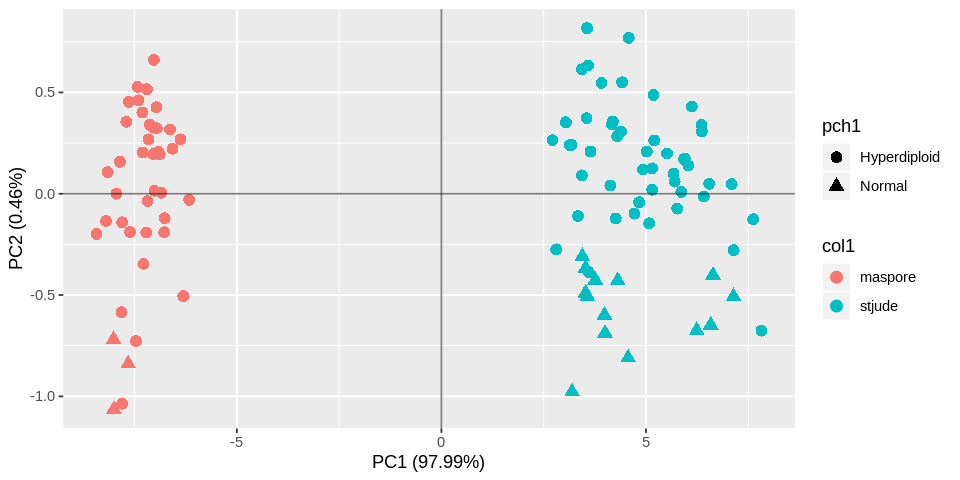

In [78]:
plotPCA2D(maspore_stjude_chr, maspore_stjude_metadata,
          "batch", "subtype")
maspore_stjude_chr